In [1]:
# we will import all the necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

In [2]:
#read in the data using geopandas
stations = gpd.read_file('data/tfl_stations.json')
lines = gpd.read_file('data/tfl_lines.json')

#project data to British National Grid
#we do this so we can work in meters
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)

## Create network

In [3]:
#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])

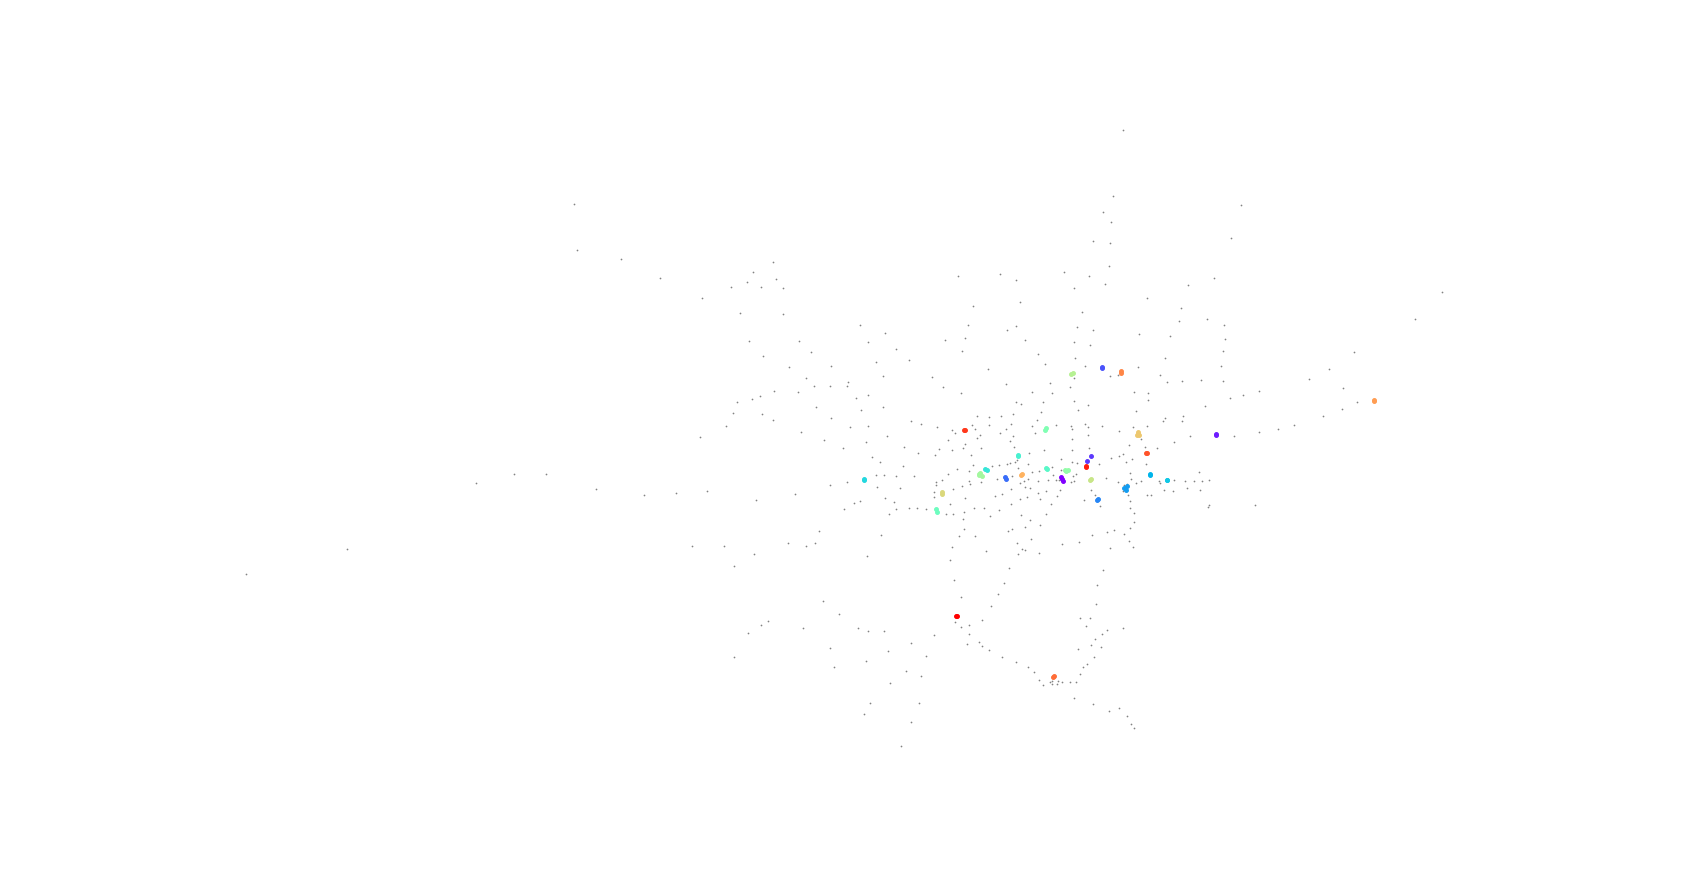

In [4]:
## we will plot all the stations with multiple points to check there are no errors
fig, ax = plt.subplots(figsize = (30,30))
ax.set_aspect("equal")
ax.axis('off')
ax.margins(0.2)
color = iter(cm.rainbow(np.linspace(0, 1, 29)))
stations.plot(ax=ax, color='grey', markersize=0.5)
for i, group in stations.groupby('name'):
    if len(group)>1:
        group.plot(ax=ax, color = next(color), markersize=15)
plt.show()

In [5]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

In [6]:
#set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))

<AxesSubplot:>

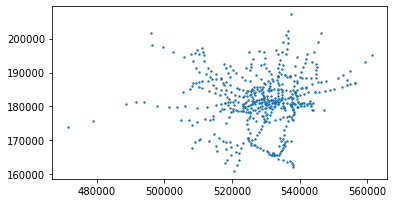

In [7]:
#check plot to make sure there are no errors
stations.plot(markersize=2)

### Lines file

In [8]:
lines.head()

,id,lines,geometry
0,LeaValleyLine1,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (534726.021 182339.910, 534747.550 ..."
1,LeaValleyLine2,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (534826.495 183293.130, 534820.978 ..."
2,LeaValleyLine3,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (534783.192 184262.624, 534785.835 ..."
3,LeaValleyLine4,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (534530.346 185136.490, 534525.951 ..."
4,LeaValleyLine5,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (533996.588 186186.930, 533979.709 ..."


In [9]:
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names

['Thameslink 6tph line',
 'Metropolitan',
 'Jubilee',
 'District',
 'London Overground',
 'Piccadilly',
 'Emirates Air Line',
 'Circle',
 'Northern',
 'Victoria',
 'Central',
 'Waterloo & City',
 'DLR',
 'East London',
 'TfL Rail',
 'Crossrail 2',
 'Bakerloo',
 'Hammersmith & City',
 'Crossrail',
 'Tramlink']

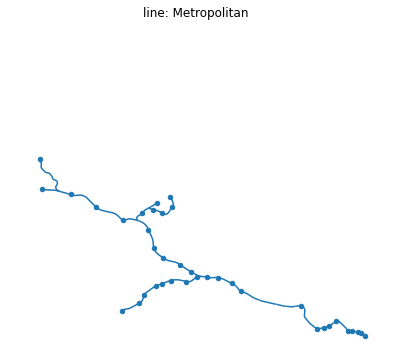

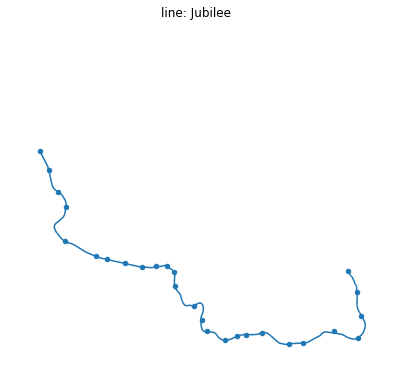

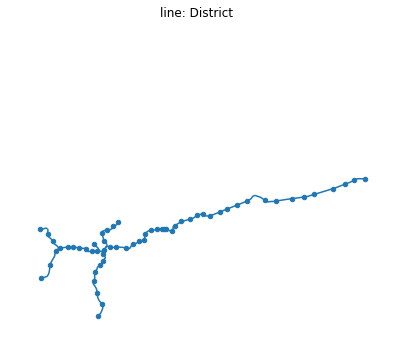

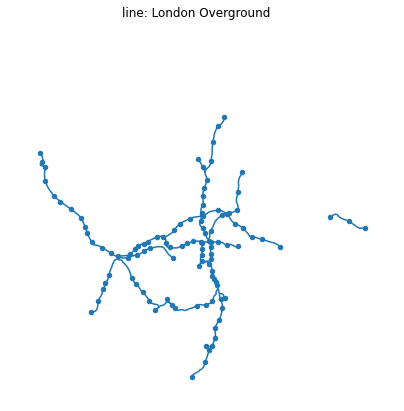

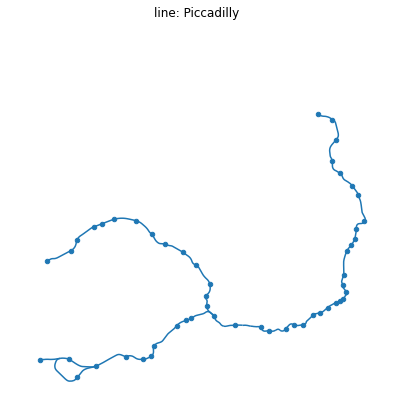

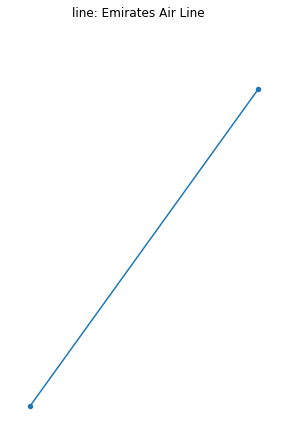

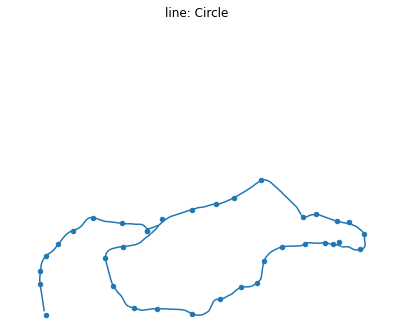

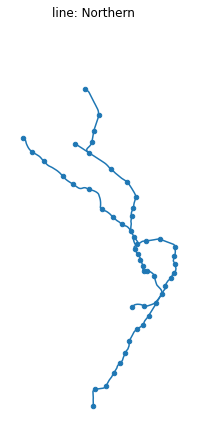

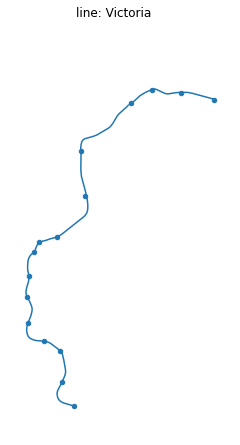

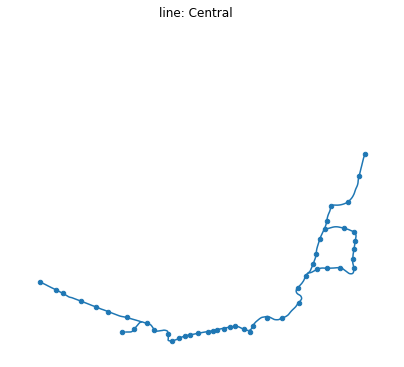

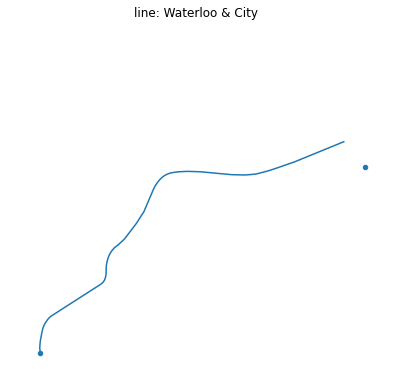

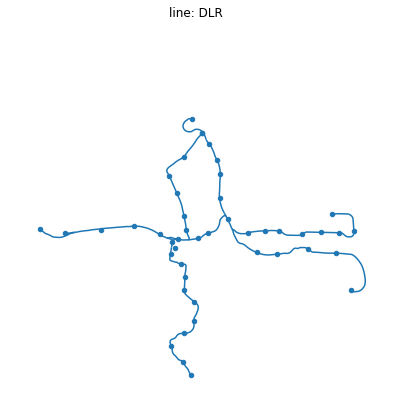

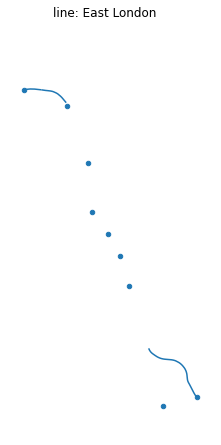

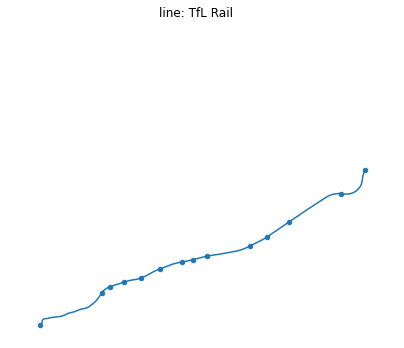

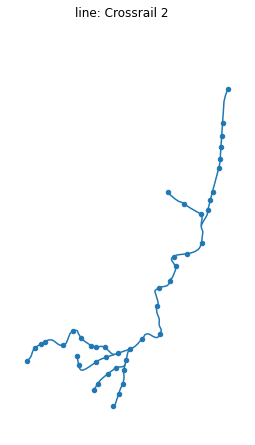

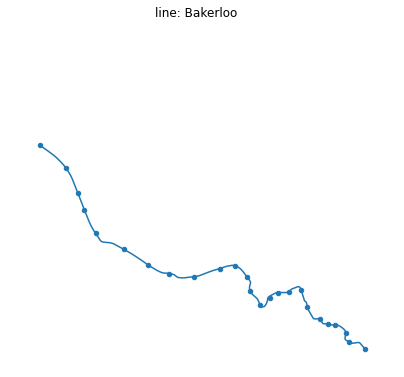

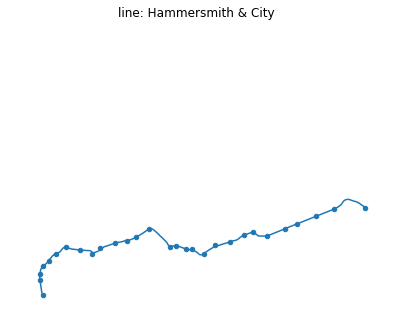

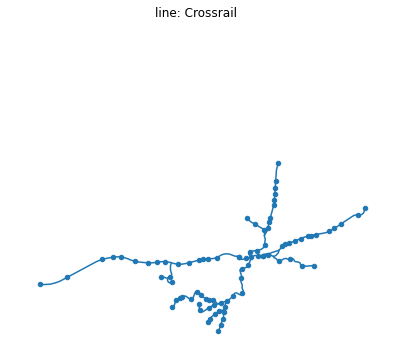

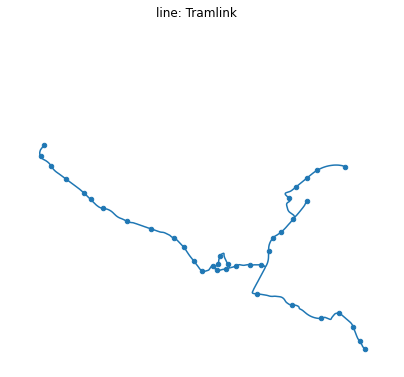

In [10]:
# check the data for each line
for line in line_names:
    #I'm removing thameslink 6tph line because there are not corresponding stations in station file
    if line == 'Thameslink 6tph line':
        continue
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    temp_lines = lines[lines.lines.str.contains(line)]
    base = temp_lines.plot(ax=ax)
    temp_stations = stations[stations.lines.str.contains(line)]
    temp_stations.plot(ax=base, markersize=20)
    plt.show()

In [11]:
#We can see that east london line is incomplete
#digging into this however we notice that it's because east london is actually part of the overground
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')

In [12]:
#Our TFL data doesn't include tramlink, emirates air lines, and crossrail is still in construction
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']

### Create seperate graphs for each line and then join

Metropolitan


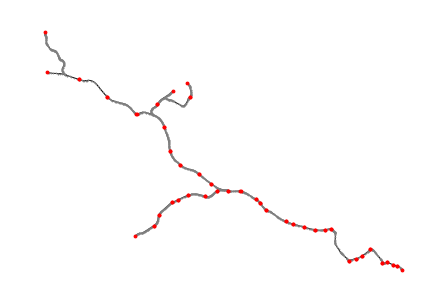

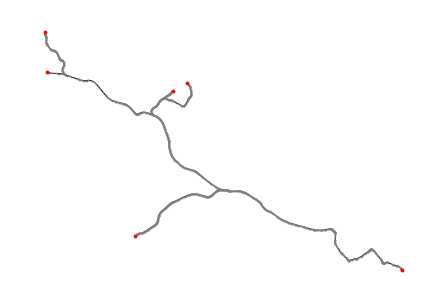

1
Jubilee


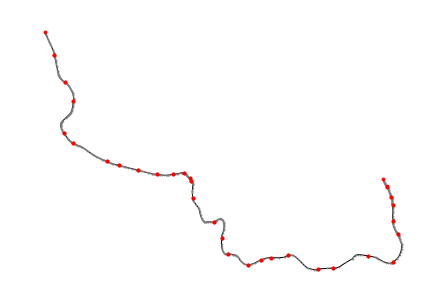

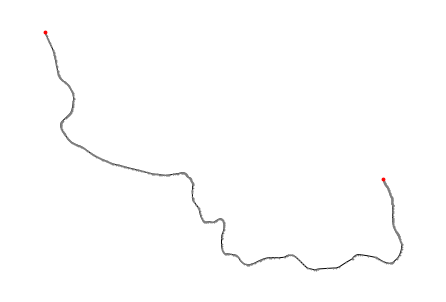

1
District


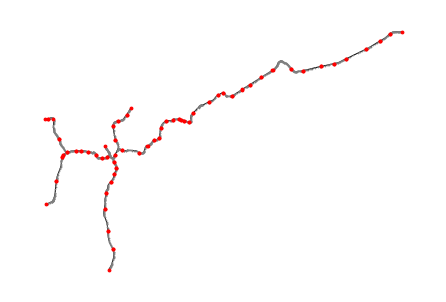

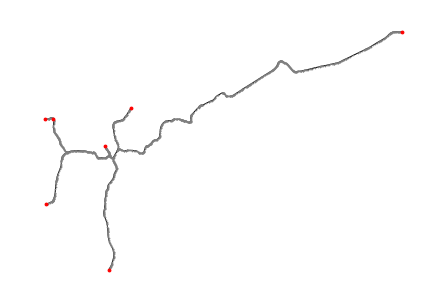

1
London Overground


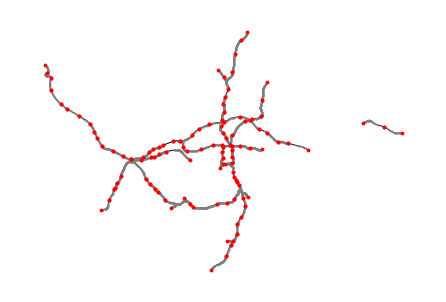

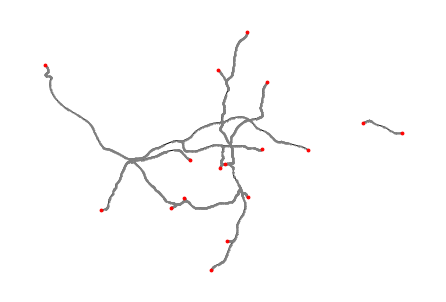

3
Piccadilly


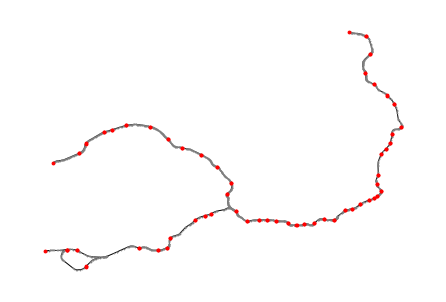

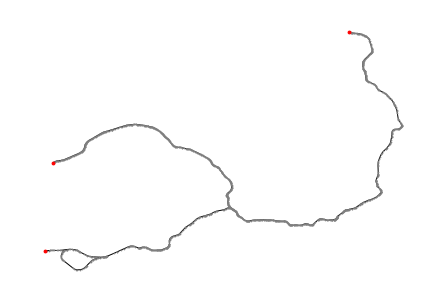

1
Circle


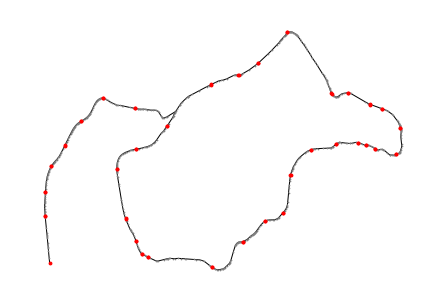

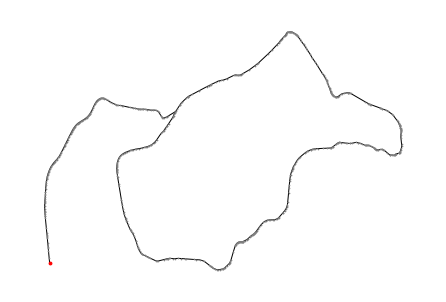

1
Northern


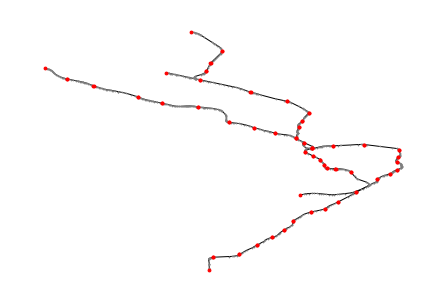

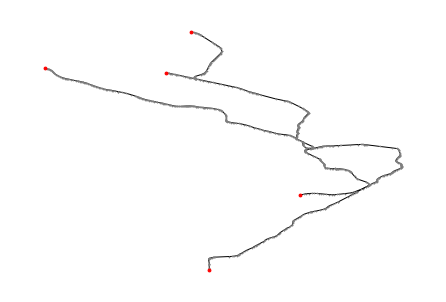

1
Victoria


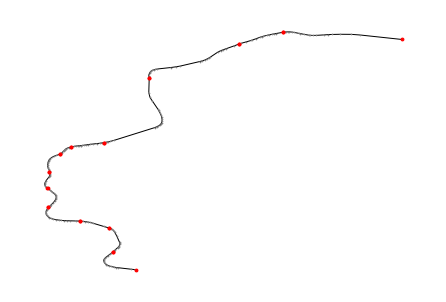

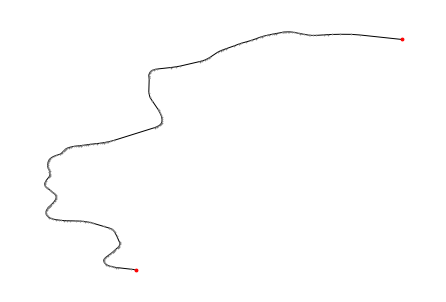

1
Central


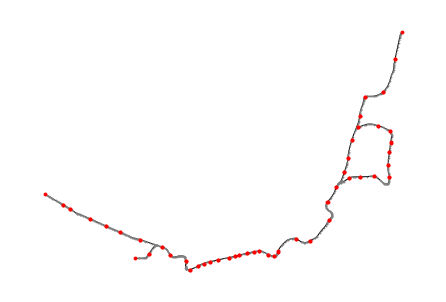

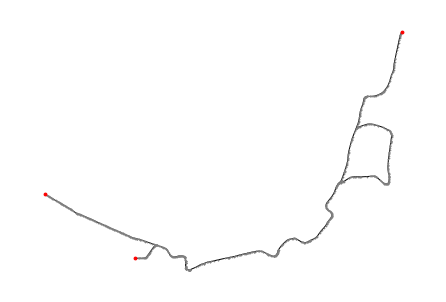

1
Waterloo & City


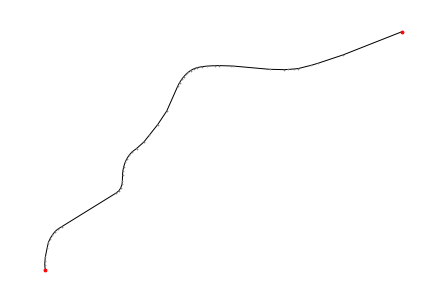

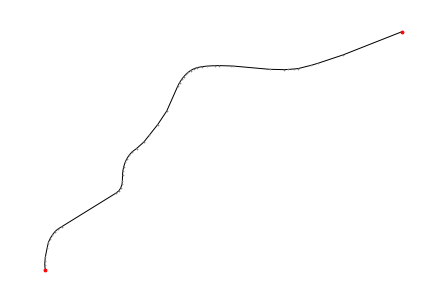

1
DLR


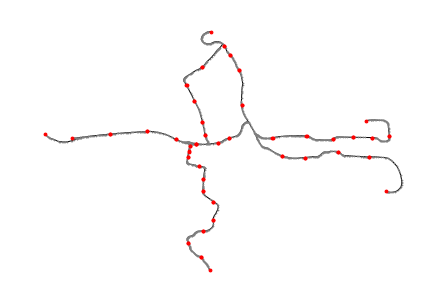

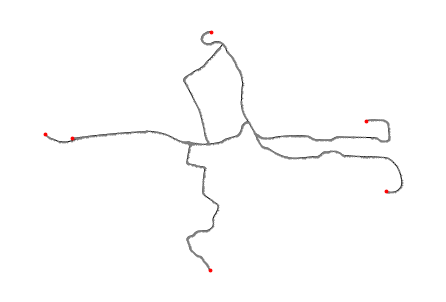

1
TfL Rail


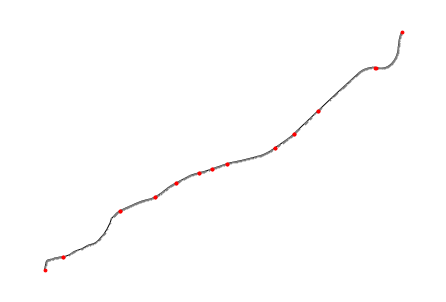

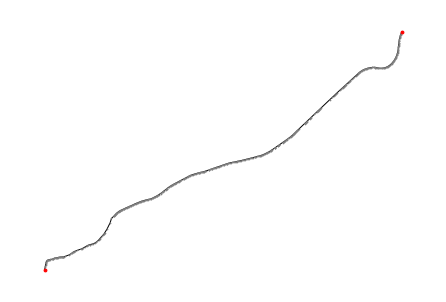

1
Bakerloo


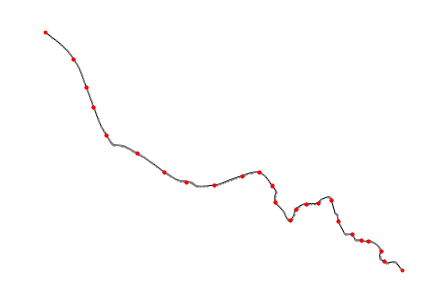

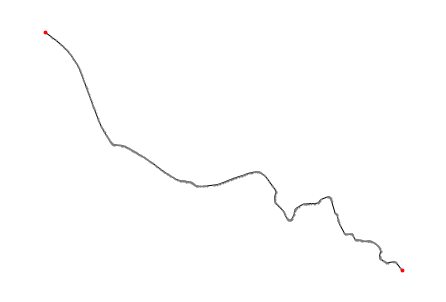

1
Hammersmith & City


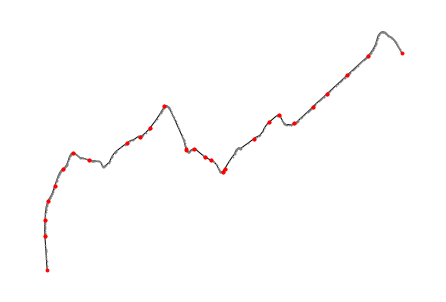

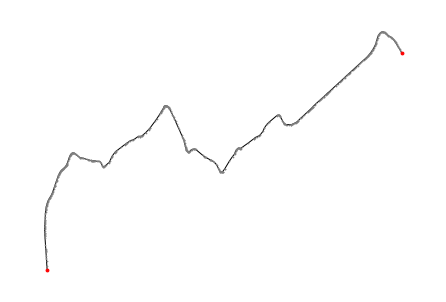

1


In [13]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G

In [14]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })

,line_name,start_id,end_id,geometry
0,Metropolitan,940GZZLUUXB,940GZZLUHGD,"LINESTRING (505607.227 184156.938, 507546.292 ..."
1,Metropolitan,940GZZLUHGD,940GZZLUICK,"LINESTRING (507546.292 185008.855, 508091.243 ..."
2,Metropolitan,940GZZLUICK,940GZZLURSP,"LINESTRING (508091.243 185937.970, 509484.647 ..."
3,Metropolitan,940GZZLURSP,940GZZLURSM,"LINESTRING (509484.647 187013.725, 510120.308 ..."
4,Metropolitan,940GZZLURSM,940GZZLUEAE,"LINESTRING (510120.308 187242.734, 511173.419 ..."


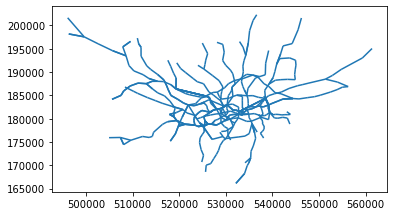

In [15]:
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs
edge_gdf.plot()
edge_gdf.head()

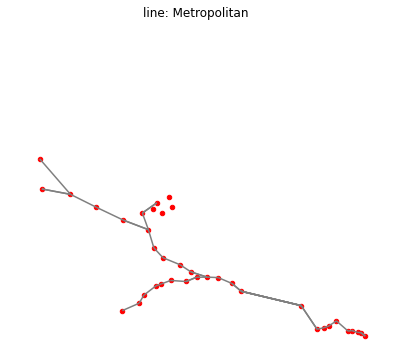

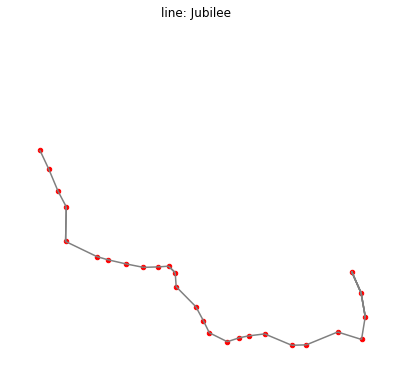

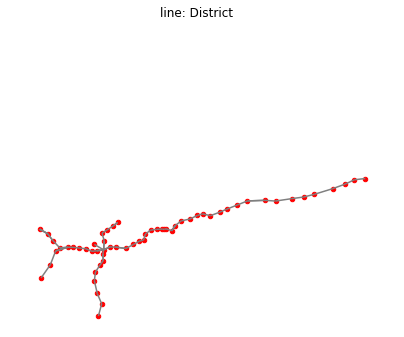

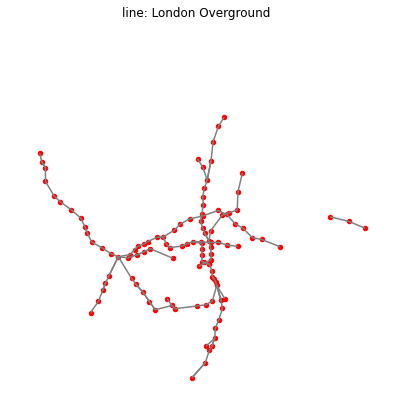

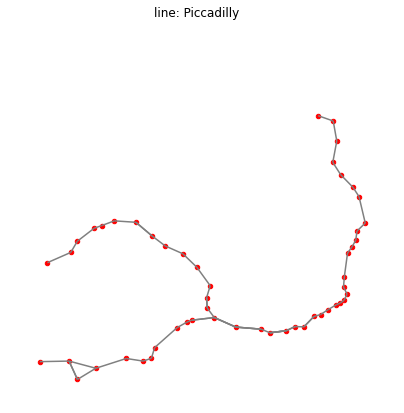

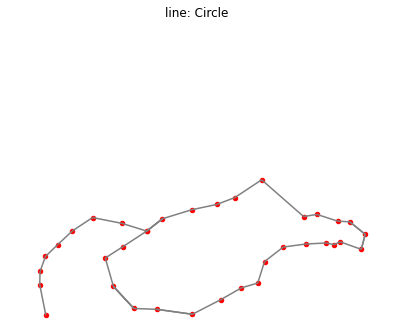

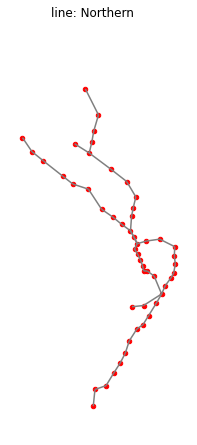

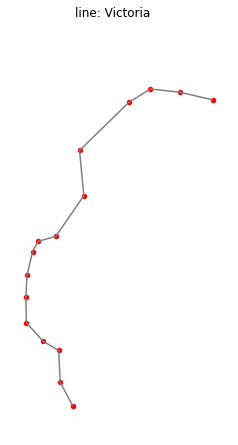

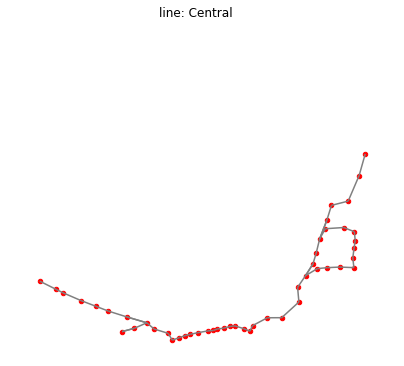

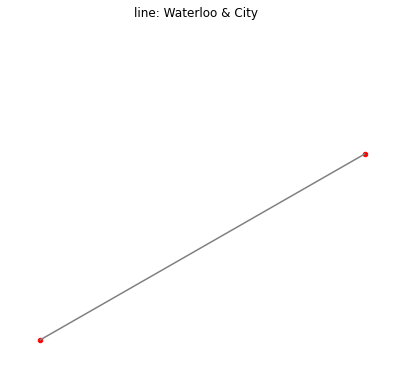

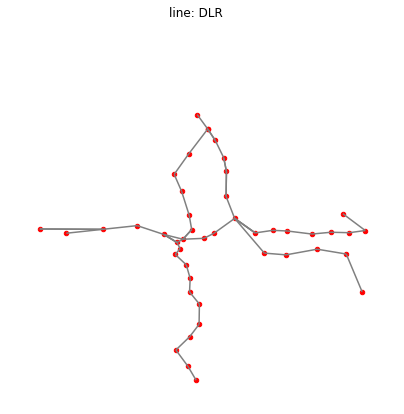

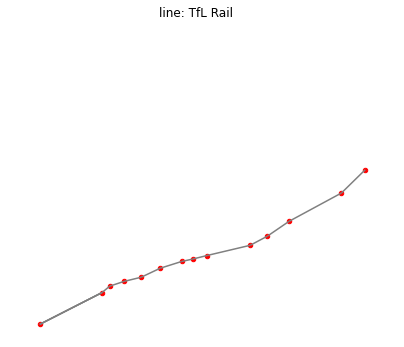

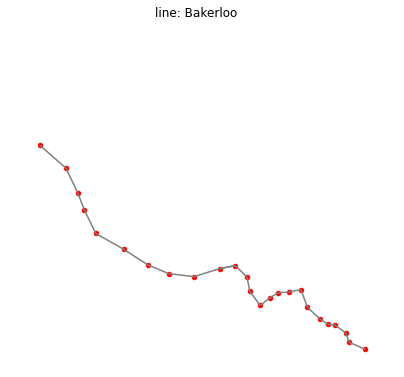

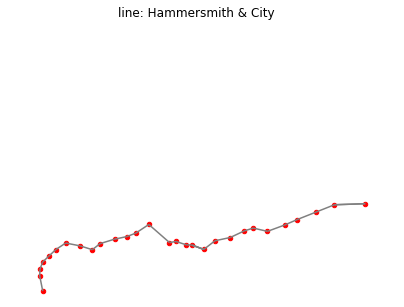

In [16]:
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

<AxesSubplot:>

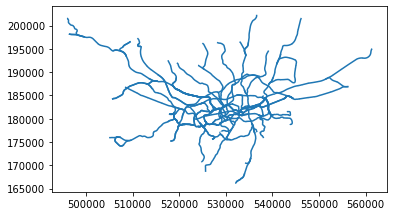

In [17]:
#plot to sanity check
edge_gdf.plot()

In [18]:
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

In [19]:
#this is our resulting dataframe
edge_gdf.head()

,line_name,start_id,end_id,geometry,length
0,Metropolitan,940GZZLUUXB,940GZZLUHGD,"LINESTRING (505607.227 184156.938, 505608.492 ...",2144.395127
1,Metropolitan,940GZZLUHGD,940GZZLUICK,"LINESTRING (507546.292 185008.855, 507547.596 ...",1124.437195
2,Metropolitan,940GZZLUICK,940GZZLURSP,"LINESTRING (508091.243 185937.970, 508090.413 ...",1785.654982
3,Metropolitan,940GZZLURSP,940GZZLURSM,"LINESTRING (509484.647 187013.725, 509485.975 ...",678.885980
4,Metropolitan,940GZZLURSM,940GZZLUEAE,"LINESTRING (510120.308 187242.734, 510121.638 ...",1126.239052


In [20]:
#let's replace the ids with the actual nane
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

In [21]:
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

In [22]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

{'Circle', 'TfL Rail', 'Northern', 'Victoria', 'Central', 'Metropolitan', 'Bakerloo', 'Waterloo & City', 'Jubilee', 'District', 'London Overground', 'DLR', 'Hammersmith & City', 'Piccadilly'}


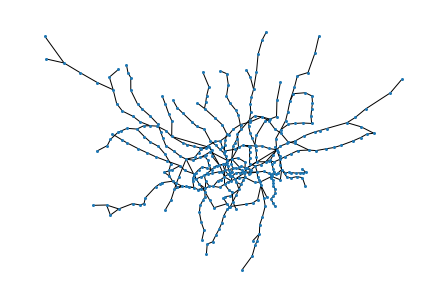

In [23]:
#let's plot
#notice that even though we created the real geometries, the graph still plots just straight line
#this is because networkx doesn't have a concept of a edge geometry
#however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

In [24]:
#save position to graph
nx.set_node_attributes(G, pos, 'coords')

In [25]:
list(G.nodes(data = True))[0]

('Uxbridge', {'coords': (505607.22735128173, 184156.93759421847)})

In [26]:
list(G.edges(data = True))[0]

('Uxbridge',
 'Hillingdon',
 {'length': 2144.395127372446, 'line_name': 'Piccadilly'})

In [27]:
# we can also add the stations name to the edge attributes from the nodes attributes:

nod_name1={(e1,e2):e1 for e1, e2 in G.edges()}
nod_name2={(e1,e2):e2 for e1, e2 in G.edges()}
nod_name3={e1:e1 for e1 in G.nodes()}

nx.set_edge_attributes(G,nod_name1,'station_1_')
nx.set_edge_attributes(G,nod_name2,'station_2_')
nx.set_node_attributes(G,nod_name3,'station_name')

In [28]:
#check
list(G.edges(data = True))[0]

('Uxbridge',
 'Hillingdon',
 {'length': 2144.395127372446,
  'line_name': 'Piccadilly',
  'station_1_': 'Uxbridge',
  'station_2_': 'Hillingdon'})

In [29]:
#check
list(G.nodes(data = True))[0]

('Uxbridge',
 {'coords': (505607.22735128173, 184156.93759421847),
  'station_name': 'Uxbridge'})

In [30]:
#check that all distances are greater or equal to euclidean distance
for u,v, data in G.edges(data=True):
    assert(data['length'] >= distance.euclidean(pos[u], pos[v]))

In [31]:
#if want to know to which stations Baker Street is directly connected to
Baker_Street = [(u,v) for  u,v in G.edges() if u == 'Baker Street' or v == 'Baker Street']
Baker_Street

[('Baker Street', 'Great Portland Street'),
 ('Baker Street', 'Finchley Road'),
 ('Baker Street', 'Bond Street'),
 ('Baker Street', "St. John's Wood"),
 ('Baker Street', 'Edgware Road'),
 ('Baker Street', 'Marylebone'),
 ('Baker Street', "Regent's Park")]

In [32]:
#We can also check the degree of the nodes in our network and check that they make sense
deg_london = nx.degree(G)

In [33]:
df = pd.DataFrame(index = dict(deg_london).keys())
df['degree'] = dict(deg_london).values()

In [34]:
df.sort_values('degree', ascending =False).head(10)

,degree
Stratford,9
Bank and Monument,8
King's Cross St. Pancras,7
Baker Street,7
Liverpool Street,6
Green Park,6
Oxford Circus,6
Earl's Court,6
Waterloo,6
Canning Town,6


In [35]:
G.number_of_nodes()

401

In [36]:
G.number_of_edges()

467

## Topology

### Centrality measures

#### Degree Centrality on nodes:

In [37]:
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')

In [38]:
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))

degree_sorted = df.sort_values(["degree"], ascending=False)
degree_sorted[0:10]

,station_name,degree
Stratford,Stratford,0.0225
Bank and Monument,Bank and Monument,0.0200
King's Cross St. Pancras,King's Cross St. Pancras,0.0175
Baker Street,Baker Street,0.0175
Liverpool Street,Liverpool Street,0.0150
Green Park,Green Park,0.0150
Oxford Circus,Oxford Circus,0.0150
Earl's Court,Earl's Court,0.0150
Waterloo,Waterloo,0.0150
Canning Town,Canning Town,0.0150


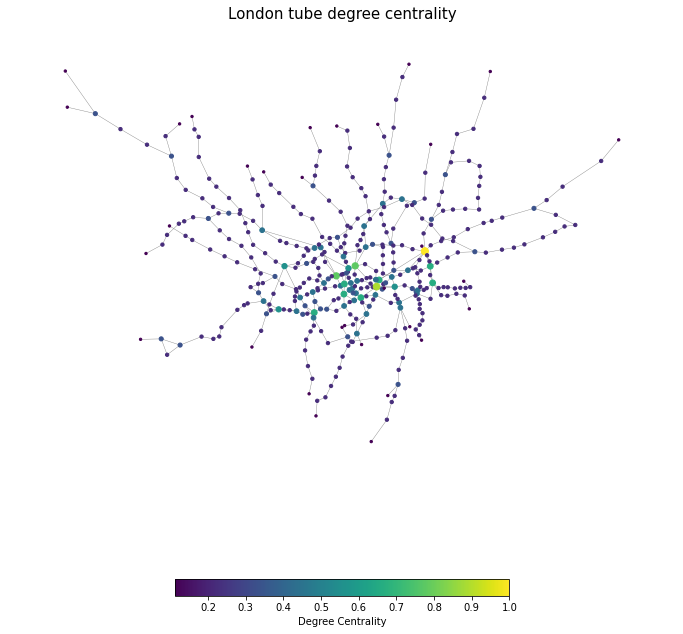

In [39]:
# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['degree']) for i in G.nodes(data=True)]

deg_color=[(i[1]['degree']/(max(degree_values))) for i in G.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G.nodes(data=True)]



# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)

plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube degree centrality",fontsize=15)
plt.show()

#### Betweenness Centrality on nodes:

In [40]:
### Topological betweenness centrality:

#Let us compute the betweenness centrality for the network, without using weights:
bet_london_t=nx.betweenness_centrality(G, normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_t,'betweenness_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))

betweenness_sorted = df.sort_values(["betweenness_t"], ascending=False)
betweenness_sorted[0:10]

,station_name,betweenness_t
Stratford,Stratford,23768.093434
Bank and Monument,Bank and Monument,23181.058947
Liverpool Street,Liverpool Street,21610.387049
King's Cross St. Pancras,King's Cross St. Pancras,20373.521465
Waterloo,Waterloo,19464.882323
Green Park,Green Park,17223.622114
Euston,Euston,16624.275469
Westminster,Westminster,16226.155916
Baker Street,Baker Street,15287.107612
Finchley Road,Finchley Road,13173.758009


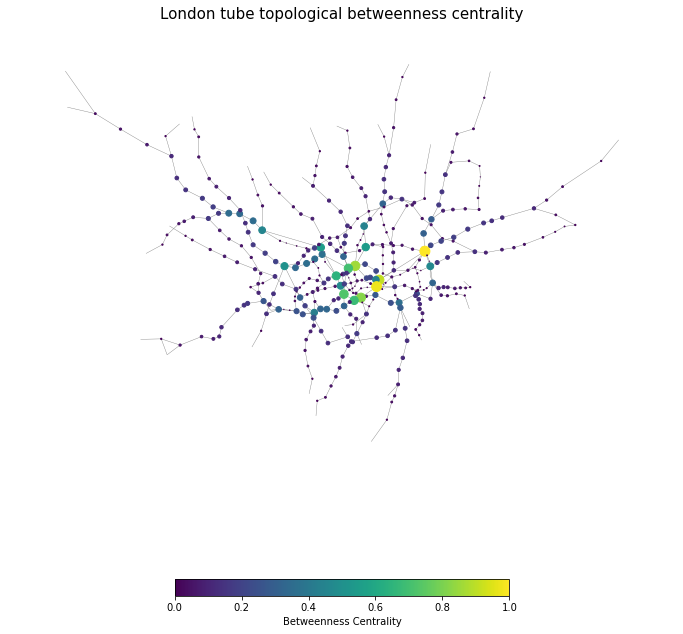

In [41]:
# Lets set colour and size of nodes according to betweenness values
betweenness_t_values=[(i[1]['betweenness_t']) for i in G.nodes(data=True)]

bet_t_color=[(i[1]['betweenness_t']/max(betweenness_t_values)) for i in G.nodes(data=True)]
bet_t_size=[(i[1]['betweenness_t']/max(betweenness_t_values))*100 for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(G, pos = pos, node_color= bet_t_color, node_size= bet_t_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological betweenness centrality",fontsize=15)
plt.show()

#### Closeness Centrality:

In [42]:
#topological closeness centrality
clos_t=nx.closeness_centrality(G)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,clos_t,'closeness_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['closeness_t'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))

closeness_sorted = df.sort_values(["closeness_t"], ascending=False)
closeness_sorted[0:10]

,station_name,closeness_t
Green Park,Green Park,0.114778
Bank and Monument,Bank and Monument,0.113572
King's Cross St. Pancras,King's Cross St. Pancras,0.113443
Westminster,Westminster,0.112549
Waterloo,Waterloo,0.112265
Oxford Circus,Oxford Circus,0.111204
Bond Street,Bond Street,0.110988
Angel,Angel,0.110742
Farringdon,Farringdon,0.110742
Moorgate,Moorgate,0.110314


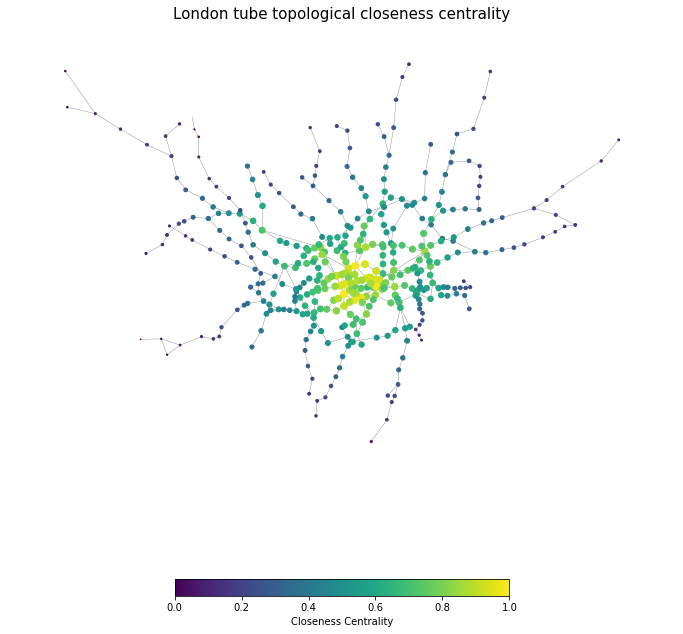

In [43]:
# Lets set color and width of nodes according to the closeness values
clos_t_val=[(i[1]['closeness_t']) for i in G.nodes(data=True)]

closs_t_color=[(i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val)) for i in G.nodes(data=True)]
closs_t_size=[((i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val))*50) for i in G.nodes(data=True)]


# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= closs_t_color,
        node_size= closs_t_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological closeness centrality",fontsize=15)
plt.show()

### Impact of node removal

#### Non-sequential removal:

In [44]:
G2=G.copy()

In [45]:
def distance_eff(Graph):
    distance = pd.DataFrame()
    
    for i in list(Graph.nodes()):
        distance_dict=dict()
        for j in list(Graph.nodes()):
            if nx.has_path(Graph, source=i, target=j):
                length = nx.shortest_path_length(Graph, source=i, target=j)
                if length != 0:
                    length = 1/length
                    distance_dict[j]=length
            else:
                distance_dict[j]=0
        
        distance_origin = pd.DataFrame.from_dict(distance_dict, orient='index')
        distance = pd.concat([distance, distance_origin], axis=1)
        
    distance['Row_sum'] = distance.apply(lambda x: x.sum(), axis=1)
    distance.loc['Col_sum'] = distance.apply(lambda x: x.sum())
    return distance

In [46]:
def effect(Graph):
     # we can see in the plot that the graph has more then one component
    # let's subset this graph to the largest connected component
    Gcc = sorted(nx.connected_components(Graph), key=len, reverse=True)
    Gsub = Graph.subgraph(Gcc[0])
    
    # calculate the percentage of nodes present in the largest connected components
    percent_lcc = (len(Gsub.nodes)/len(Graph.nodes)) * 100
    percent_lcc = round(percent_lcc,2)
    
    le = len(list(Graph.nodes))
    nlen = {n:nx.single_source_dijkstra_path_length(Graph, n, weight='length') for n in Graph.nodes()}
    E = 1/(le*(le-1))* distance_eff(Graph).loc['Col_sum', 'Row_sum']
    E = round(E, 8)
    
    return percent_lcc, E

In [47]:
original_percent_lcc, original_E = effect(G2)
print(f'lcc: {original_percent_lcc}')
print(f'Efficiency: {original_E}')

lcc: 100.0
Efficiency: 0.10125619


##### Degree

In [128]:
G2=G.copy()
i = 0
removal_results = dict()
removal_results['original']=[original_percent_lcc, original_E]

while i<10:
#betweenness_t_values=[(i[1]['degree']) for i in G2.nodes(data=True)]
    maxbet=[degree_sorted.iloc[i, 0]]
    #To remove nodes:
    G2.remove_nodes_from(maxbet)
    
    # we can see in the plot that the graph has more then one component
    # let's subset this graph to the largest connected component
    #Gcc = sorted(nx.connected_components(G2), key=len, reverse=True)
    #Gsub = G2.subgraph(Gcc[0])
    
    percent_lcc, E = effect(G2)
    
    removal_results[degree_sorted.iloc[i, 0]] = [percent_lcc, E]
    i += 1

removal_effect_degree = pd.DataFrame.from_dict(removal_results, orient='index', columns=['LCC (%)', 'Efficiency'])
removal_effect_degree = removal_effect_degree.reset_index()
removal_effect_degree = removal_effect_degree.rename({'index':'remove_station_name'}, axis=1)
removal_effect_degree

,remove_station_name,LCC (%),Efficiency
0,original,100.00,0.101256
1,Stratford,94.75,0.088917
2,Bank and Monument,94.74,0.085862
3,King's Cross St. Pancras,94.72,0.080287
4,Baker Street,94.21,0.075700
5,Liverpool Street,92.93,0.073903
6,Green Park,92.91,0.072873
7,Oxford Circus,92.64,0.071765
8,Earl's Court,92.62,0.070082
9,Waterloo,92.60,0.068257


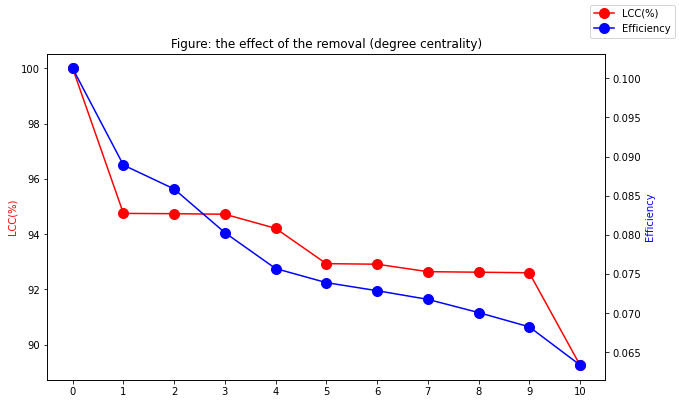

In [129]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.plot(removal_effect_degree['LCC (%)'] , marker='.', color='r', ms=20, label='LCC(%)')
ax1.set_ylabel('LCC(%)', color='r')
#plt.ylim([0, 100])
plt.xticks(range(0,len(removal_effect_degree.index.to_list())), removal_effect_degree.index,color='black')
ax2 = ax1.twinx()
ax2.plot(removal_effect_degree['Efficiency'] , marker='.', color='b', ms=20, label='Efficiency')
ax2.set_ylabel('Efficiency', color='b')
#plt.ylim([0, 0.00008])
fig.legend(loc=1)
plt.title('Figure: the effect of the removal (degree centrality)')
plt.show()

##### Betweenness

In [130]:
G2=G.copy()
i = 0
removal_results = dict()
removal_results['original']=[original_percent_lcc, original_E]


while i<10:
    #betweenness_t_values=[(i[1]['degree']) for i in G2.nodes(data=True)]
    maxbet=[betweenness_sorted.iloc[i, 0]]
    #To remove nodes:
    G2.remove_nodes_from(maxbet)
    
    # we can see in the plot that the graph has more then one component
    # let's subset this graph to the largest connected component
    #Gcc = sorted(nx.connected_components(G2), key=len, reverse=True)
    #Gsub = G2.subgraph(Gcc[0])
    
    percent_lcc, E = effect(G2)
    
    removal_results[f'{betweenness_sorted.iloc[i, 0]}'] = [percent_lcc, E]
    i += 1

removal_effect_betweenness = pd.DataFrame.from_dict(removal_results, orient='index', columns=['LCC (%)', 'Efficiency'])
removal_effect_betweenness = removal_effect_betweenness.reset_index()
removal_effect_betweenness = removal_effect_betweenness.rename({'index':'remove_station_name'}, axis=1)
removal_effect_betweenness

,remove_station_name,LCC (%),Efficiency
0,original,100.00,0.101256
1,Stratford,94.75,0.088917
2,Bank and Monument,94.74,0.085862
3,Liverpool Street,94.72,0.084963
4,King's Cross St. Pancras,93.45,0.078498
5,Waterloo,93.43,0.075942
6,Green Park,93.42,0.074152
7,Euston,87.82,0.068206
8,Westminster,87.79,0.067659
9,Baker Street,87.24,0.064700


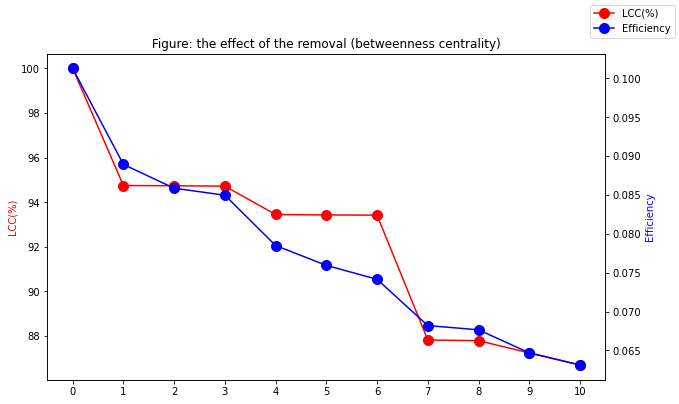

In [131]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.plot(removal_effect_betweenness['LCC (%)'] , marker='.', color='r', ms=20, label='LCC(%)')
#plt.ylim([0, 100])
ax1.set_ylabel('LCC(%)', color='r')
plt.xticks(range(0,len(removal_effect_betweenness.index.to_list())), removal_effect_betweenness.index,color='black')
ax2 = ax1.twinx()
ax2.plot(removal_effect_betweenness['Efficiency'] , marker='.', color='b', ms=20, label='Efficiency')
#plt.ylim([0, 0.00008])
ax2.set_ylabel('Efficiency', color='b')
fig.legend(loc=1)
plt.title('Figure: the effect of the removal (betweenness centrality)')
plt.show()

##### Closeness

In [132]:
G2=G.copy()
i = 0
removal_results = dict()
removal_results['original']=[original_percent_lcc, original_E]


while i<10:
    #betweenness_t_values=[(i[1]['degree']) for i in G2.nodes(data=True)]
    maxbet=[closeness_sorted.iloc[i, 0]]
    #To remove nodes:
    G2.remove_nodes_from(maxbet)
    
    # we can see in the plot that the graph has more then one component
    # let's subset this graph to the largest connected component
    #Gcc = sorted(nx.connected_components(G2), key=len, reverse=True)
    #Gsub = G2.subgraph(Gcc[0])
    
    percent_lcc, E = effect(G2)
    
    removal_results[f'{closeness_sorted.iloc[i, 0]}'] = [percent_lcc, E]
    i += 1

removal_effect_closeness = pd.DataFrame.from_dict(removal_results, orient='index', columns=['LCC (%)', 'Efficiency'])
removal_effect_closeness = removal_effect_closeness.reset_index()
removal_effect_closeness = removal_effect_closeness.rename({'index':'remove_station_name'}, axis=1)
removal_effect_closeness

,remove_station_name,LCC (%),Efficiency
0,original,100.00,0.101256
1,Green Park,100.00,0.099190
2,Bank and Monument,100.00,0.094872
3,King's Cross St. Pancras,100.00,0.087934
4,Westminster,100.00,0.087372
5,Waterloo,100.00,0.084859
6,Oxford Circus,100.00,0.082781
7,Bond Street,100.00,0.082581
8,Angel,100.00,0.082600
9,Farringdon,100.00,0.082622


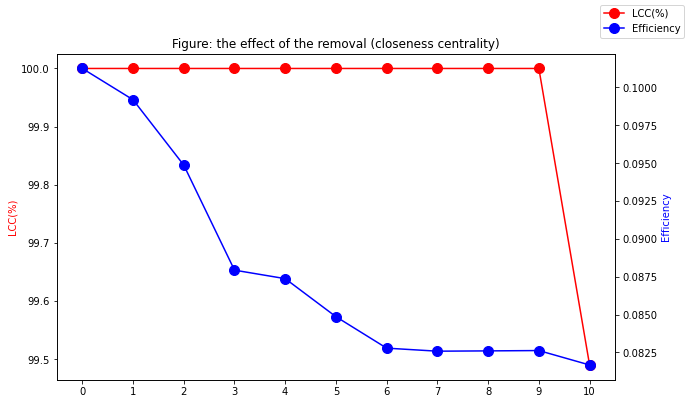

In [133]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.plot(removal_effect_closeness['LCC (%)'] , marker='.', color='r', ms=20, label='LCC(%)')
ax1.set_ylabel('LCC(%)', color='r')
#plt.ylim([0, 100])
plt.xticks(range(0,len(removal_effect_closeness.index.to_list())), removal_effect_closeness.index,color='black')
ax2 = ax1.twinx()
ax2.plot(removal_effect_closeness['Efficiency'] , marker='.', color='b', ms=20, label='Efficiency')
ax2.set_ylabel('Efficiency', color='b')
#plt.ylim([0, 0.00008])
fig.legend(loc=1)
plt.title('Figure: the effect of the removal (closeness centrality)')
plt.show()

#### Sequential removal:

##### Preparation and function

In [54]:
G3=G.copy()

In [55]:
def get_new_centrality(method, G):
    if method == 'degree_centrality':
        cen_london = nx.degree_centrality(G)
    if method == 'betweenness_centrality':
        cen_london = nx.betweenness_centrality(G)
    else:
        cen_london = nx.closeness_centrality(G)
        
    nx.set_node_attributes(G,dict(cen_london),method)
    df = pd.DataFrame(index=G.nodes())
    df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
    df[method] = pd.Series(nx.get_node_attributes(G, method))
    df_sorted = df.sort_values([method], ascending=False)
    return df_sorted

##### Degree

In [134]:
G3=G.copy()
i = 0
removal_results = dict()
removal_results['original']=[original_percent_lcc, original_E]

while i<10:
    cen_london = nx.degree_centrality(G3)
    nx.set_node_attributes(G3,dict(cen_london),'degree_centrality')
    
    df = pd.DataFrame(index=G3.nodes())
    df['station_name'] = pd.Series(nx.get_node_attributes(G3, 'station_name'))
    df['degree_centrality'] = pd.Series(nx.get_node_attributes(G3, 'degree_centrality'))
    df_sorted_dc = df.sort_values(['degree_centrality'], ascending=False)
    
    node_to_remove = df_sorted_dc.index[0]
    G3.remove_node(node_to_remove)
    
    # we can see in the plot that the graph has more then one component
    # let's subset this graph to the largest connected component
    #Gcc = sorted(nx.connected_components(G2), key=len, reverse=True)
    #Gsub = G2.subgraph(Gcc[0])
    
    percent_lcc, E = effect(G3)
    removal_results[node_to_remove] = [percent_lcc, E]
    i += 1

removal_effect_degree2 = pd.DataFrame.from_dict(removal_results, orient='index', columns=['LCC(%)', 'Efficiency'])
removal_effect_degree2 = removal_effect_degree2.reset_index()
removal_effect_degree2 = removal_effect_degree2.rename({'index':'remove_station_name'}, axis=1)
removal_effect_degree2

,remove_station_name,LCC(%),Efficiency
0,original,100.00,0.101256
1,Stratford,94.75,0.088917
2,Bank and Monument,94.74,0.085862
3,Baker Street,94.72,0.082033
4,King's Cross St. Pancras,94.21,0.075700
5,Earl's Court,94.19,0.074036
6,Green Park,94.18,0.073004
7,Canning Town,90.86,0.067772
8,Waterloo,90.84,0.065936
9,Willesden Junction,87.50,0.057790


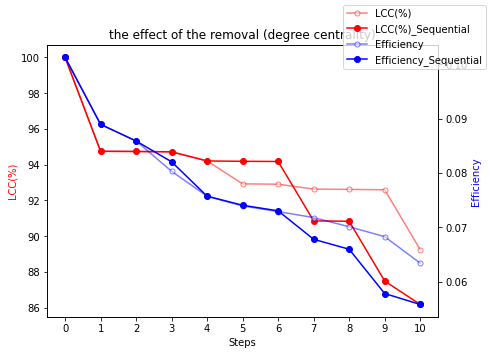

In [142]:
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Steps')
ax1.plot(removal_effect_degree['LCC (%)'] , marker='o', color='r', mfc = "white", alpha=0.5 , ms=5, label='LCC(%)')
ax1.plot(removal_effect_degree2['LCC(%)'] , marker='.', color='r', ms=12, label='LCC(%)_Sequential')
ax1.set_ylabel('LCC(%)', color='r')
#plt.ylim([0, 100])
plt.xticks(range(0,len(removal_effect_degree2.index.to_list())), removal_effect_degree2.index,color='black')
ax2 = ax1.twinx()
ax2.plot(removal_effect_degree['Efficiency'] , marker='o', mfc = "white", color='b', alpha=0.5, ms=5, label='Efficiency')
ax2.plot(removal_effect_degree2['Efficiency'] , marker='.', color='b', ms=12, label='Efficiency_Sequential')
ax2.set_ylabel('Efficiency', color='b')
#plt.ylim([0, 0.00008])
fig.legend(loc=1)
plt.title('the effect of the removal (degree centrality)')
fig.savefig('the effect of the removal (degree centrality)')
plt.show()

##### Betweenness

In [136]:
G3=G.copy()
i = 0
removal_results = dict()
removal_results['original']=[original_percent_lcc, original_E]

while i<10:
    cen_london = nx.betweenness_centrality(G3)
    nx.set_node_attributes(G3,dict(cen_london),'betweenness_centrality')
    
    df = pd.DataFrame(index=G3.nodes())
    df['station_name'] = pd.Series(nx.get_node_attributes(G3, 'station_name'))
    df['betweenness_centrality'] = pd.Series(nx.get_node_attributes(G3, 'betweenness_centrality'))
    df_sorted_dc = df.sort_values(['betweenness_centrality'], ascending=False)
    
    node_to_remove = df_sorted_dc.index[0]
    G3.remove_node(node_to_remove)
    
    # we can see in the plot that the graph has more then one component
    # let's subset this graph to the largest connected component
    #Gcc = sorted(nx.connected_components(G2), key=len, reverse=True)
    #Gsub = G2.subgraph(Gcc[0])
    
    percent_lcc, E = effect(G3)
    removal_results[node_to_remove] = [percent_lcc, E]
    i += 1

removal_effect_betweenness2 = pd.DataFrame.from_dict(removal_results, orient='index', columns=['LCC(%)', 'Efficiency'])
removal_effect_betweenness2 = removal_effect_betweenness2.reset_index()
removal_effect_betweenness2 = removal_effect_betweenness2.rename({'index':'remove_station_name'}, axis=1)
removal_effect_betweenness2

,remove_station_name,LCC(%),Efficiency
0,original,100.00,0.101256
1,Stratford,94.75,0.088917
2,King's Cross St. Pancras,94.74,0.084603
3,Waterloo,94.72,0.081829
4,Bank and Monument,94.71,0.077678
5,Canada Water,94.70,0.072832
6,West Hampstead,57.47,0.053210
7,Earl's Court,57.36,0.051656
8,Shepherd's Bush,49.87,0.045844
9,Euston,44.13,0.041631


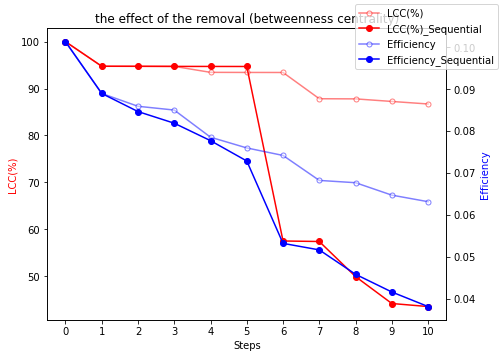

In [141]:
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Steps')
ax1.plot(removal_effect_betweenness['LCC (%)'], marker='o', color='r', mfc = "white", alpha=0.5, ms=5, label='LCC(%)')
ax1.plot(removal_effect_betweenness2['LCC(%)'], marker='.', color='r', ms=12, label='LCC(%)_Sequential')
ax1.set_ylabel('LCC(%)', color='r')
#plt.ylim([0, 100])
plt.xticks(range(0,len(removal_effect_betweenness2.index.to_list())), removal_effect_betweenness2.index,color='black')
ax2 = ax1.twinx()
ax2.plot(removal_effect_betweenness['Efficiency'], marker='o', mfc = "white", color='b', alpha=0.5, ms=5, label='Efficiency')
ax2.plot(removal_effect_betweenness2['Efficiency'], marker='.', color='b', ms=12, label='Efficiency_Sequential')
ax2.set_ylabel('Efficiency', color='b')
#plt.ylim([0, 0.00008])
fig.legend(loc=1)
plt.title('the effect of the removal (betweenness centrality)')
fig.savefig('the effect of the removal (betweenness centrality)')
fig.tight_layout()
plt.show()

##### Closeness

In [138]:
G3=G.copy()
i = 0
removal_results = dict()
removal_results['original']=[original_percent_lcc, original_E]

while i<10:
    cen_london = nx.closeness_centrality(G3)
    nx.set_node_attributes(G3,dict(cen_london),'closeness_centrality')
    
    df = pd.DataFrame(index=G3.nodes())
    df['station_name'] = pd.Series(nx.get_node_attributes(G3, 'station_name'))
    df['closeness_centrality'] = pd.Series(nx.get_node_attributes(G3, 'closeness_centrality'))
    df_sorted_dc = df.sort_values(['closeness_centrality'], ascending=False)
    
    node_to_remove = df_sorted_dc.index[0]
    G3.remove_node(node_to_remove)
    
    # we can see in the plot that the graph has more then one component
    # let's subset this graph to the largest connected component
    #Gcc = sorted(nx.connected_components(G2), key=len, reverse=True)
    #Gsub = G2.subgraph(Gcc[0])
    
    percent_lcc, E = effect(G3)
    removal_results[node_to_remove] = [percent_lcc, E]
    i += 1

removal_effect_closeness2 = pd.DataFrame.from_dict(removal_results, orient='index', columns=['LCC(%)', 'Efficiency'])
removal_effect_closeness2 = removal_effect_closeness2.reset_index()
removal_effect_closeness2 = removal_effect_closeness2.rename({'index':'remove_station_name'}, axis=1)
removal_effect_closeness2

,remove_station_name,LCC(%),Efficiency
0,original,100.00,0.101256
1,Green Park,100.00,0.099190
2,King's Cross St. Pancras,100.00,0.094435
3,Waterloo,100.00,0.091816
4,Bank and Monument,100.00,0.085426
5,West Hampstead,100.00,0.080544
6,Canada Water,57.22,0.058101
7,Stratford,57.36,0.051884
8,Earl's Court,57.25,0.050350
9,Shepherd's Bush,49.74,0.044395


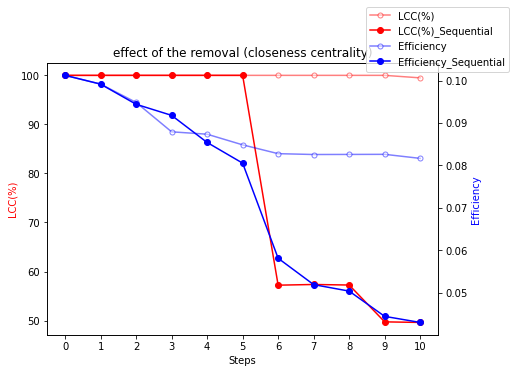

In [140]:
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Steps')
ax1.plot(removal_effect_closeness['LCC (%)'], marker='o', color='r', mfc = "white", alpha=0.5, ms=5, label='LCC(%)')
ax1.plot(removal_effect_closeness2['LCC(%)'], marker='.', color='r', ms=12, label='LCC(%)_Sequential')
ax1.set_ylabel('LCC(%)', color='r')
#plt.ylim([0, 100])
plt.xticks(range(0,len(removal_effect_closeness2.index.to_list())), removal_effect_closeness2.index,color='black')
ax2 = ax1.twinx()
ax2.plot(removal_effect_closeness['Efficiency'], marker='o', color='b', mfc = "white", alpha=0.5, ms=5, label='Efficiency')
ax2.plot(removal_effect_closeness2['Efficiency'], marker='.', color='b', ms=12, label='Efficiency_Sequential')
ax2.set_ylabel('Efficiency', color='b')
#plt.ylim([0, 0.00008])
fig.legend(bbox_to_anchor=(1.05,1.05))
plt.title('effect of the removal (closeness centrality)')
fig.savefig('the effect of the removal (closeness centrality)')
plt.show()

### Flows

#### Preparation

In [62]:
G4=G.copy()

In [63]:
flow_OD = pd.read_csv('london_flows.csv')

In [64]:
#check that our OD data and network data match
OD_names = set(flow_OD.station_origin.unique())
network_names = set([n for n in G4.nodes()])

In [65]:
#let's filter out the stations that we don't have in our network
_filter = list(network_names.symmetric_difference(OD_names))
flow_OD = flow_OD[~(flow_OD.station_origin.isin(_filter))]
flow_OD = flow_OD[~(flow_OD.station_destination.isin(_filter))]

In [66]:
#Add flow data to our network
#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G4.edges()}

In [67]:
#calculate shortest paths for all flows and add data to dict
for i, row in flow_OD.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G4, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.flows
        except:
            flows[(v,u)] += row.flows

In [68]:
#set this as a network attribute
nx.set_edge_attributes(G4, flows, 'flows')

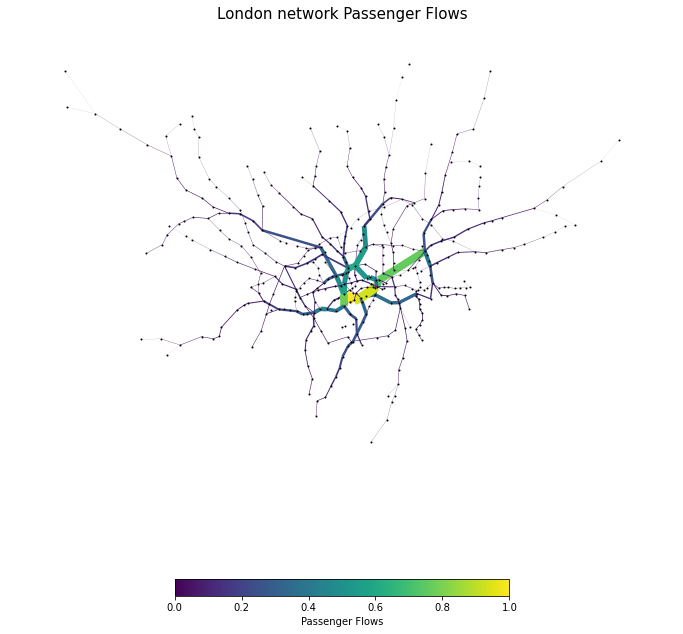

In [69]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G4.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G4.edges(data=True)]


# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G4, pos,edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G4,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

In [70]:
#get edge with highest number of flows
max(flows, key=flows.get)

('Westminster', 'Green Park')

In [71]:
#get edge data with lowest number of flows
min(flows, key=flows.get)

('Wandsworth Road', 'Battersea Park')

In [72]:
#check
df = nx.to_pandas_edgelist(G4)
df = df.sort_values('flows', ascending=False)
df[0:10]

,source,target,flows,length,line_name,station_2_,station_1_
93,Westminster,Green Park,223617,1423.780195,Jubilee,Green Park,Westminster
88,Waterloo,Westminster,211570,850.360026,Jubilee,Westminster,Waterloo
91,Waterloo,Bank and Monument,208031,2542.954444,Waterloo & City,Bank and Monument,Waterloo
99,Green Park,Victoria,172979,1209.599809,Victoria,Victoria,Green Park
14,Liverpool Street,Stratford,170712,6698.461270,TfL Rail,Stratford,Liverpool Street
13,Liverpool Street,Bank and Monument,158859,841.502684,Central,Bank and Monument,Liverpool Street
28,King's Cross St. Pancras,Euston,138757,863.369674,Victoria,Euston,King's Cross St. Pancras
100,Green Park,Oxford Circus,129262,1010.566475,Victoria,Oxford Circus,Green Park
30,King's Cross St. Pancras,Highbury & Islington,126488,2581.853010,Victoria,Highbury & Islington,King's Cross St. Pancras
96,Green Park,Bond Street,126315,1148.912313,Jubilee,Bond Street,Green Park


#### Centrality measure

In [73]:
#check
list(G4.nodes(data = True))[1]

('Hillingdon',
 {'coords': (507546.2923737053, 185008.8546307914),
  'station_name': 'Hillingdon',
  'degree': 0.005,
  'betweenness_t': 399.0,
  'closeness_t': 0.05170630816959669})

In [74]:
#check
list(G4.edges(data = True))[1]

('Hillingdon',
 'Ickenham',
 {'length': 1124.4371952028946,
  'line_name': 'Piccadilly',
  'station_1_': 'Hillingdon',
  'station_2_': 'Ickenham',
  'flows': 8453})

In [75]:
### Weighted betweenness centrality:
#Let us compute the betweenness centrality for the network, considering the distance between stations:

bet_london_w=nx.betweenness_centrality(G4, weight='flows' ,normalized=False)

# We can add these values to the nodes attributes:
nx.set_node_attributes(G4,bet_london_w,'betweenness_w')

# To dataframe using the nodes as the index
df = pd.DataFrame(index=G4.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G4, 'station_name'))
df['betweenness_w'] = pd.Series(nx.get_node_attributes(G4, 'betweenness_w'))

sorted_betweenness_w = df.sort_values(["betweenness_w"], ascending=False)
sorted_betweenness_w[0:10]

,station_name,betweenness_w
West Hampstead,West Hampstead,31457.00
Gospel Oak,Gospel Oak,23264.25
Finchley Road & Frognal,Finchley Road & Frognal,22393.75
Hampstead Heath,Hampstead Heath,22317.50
Willesden Junction,Willesden Junction,20921.75
Brondesbury,Brondesbury,19101.75
Brondesbury Park,Brondesbury Park,18936.00
Kensal Rise,Kensal Rise,18796.25
West Ham,West Ham,16695.25
Stratford,Stratford,15980.25


In [76]:
betweenness_sorted[0:10]

,station_name,betweenness_t
Stratford,Stratford,23768.093434
Bank and Monument,Bank and Monument,23181.058947
Liverpool Street,Liverpool Street,21610.387049
King's Cross St. Pancras,King's Cross St. Pancras,20373.521465
Waterloo,Waterloo,19464.882323
Green Park,Green Park,17223.622114
Euston,Euston,16624.275469
Westminster,Westminster,16226.155916
Baker Street,Baker Street,15287.107612
Finchley Road,Finchley Road,13173.758009


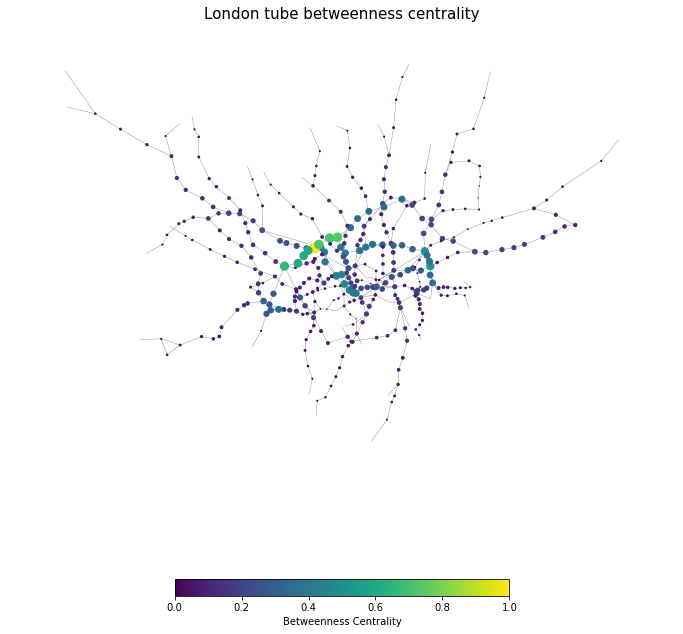

In [77]:
# Lets set colour and size of nodes according to betweenness values
betweenness_w_values=[(i[1]['betweenness_w']) for i in G4.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_w']/max(betweenness_w_values)) for i in G4.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_w']/max(betweenness_w_values))*100 for i in G4.nodes(data=True)]


# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G4, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G4,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube betweenness centrality",fontsize=15)
plt.show()

#### Removal

In [144]:
Gcc = sorted(nx.connected_components(G4), key=len, reverse=True)
Gsub = G4.subgraph(Gcc[0])

original_percent_lcc_G4 = (len(Gsub.nodes)/len(G4.nodes)) * 100
original_percent_lcc_G4 = round(original_percent_lcc_G4,2)

original_av_path = nx.average_shortest_path_length(Gsub)

le = len(list(G4.nodes))
nlen = {n:nx.single_source_dijkstra_path_length(G4, n, weight='length') for n in G4.nodes()}
original_E_G4 = 1/(le*(le-1))* distance_eff(G4).loc['Col_sum', 'Row_sum']
original_E_G4 = round(original_E_G4, 8)

##### Non-sequential removal:

In [145]:
G5=G4.copy()
i = 0
removal_results = dict()
removal_results['original']=[original_percent_lcc, original_E, original_av_path]

while i<3:
    node_to_remove = sorted_betweenness_w.index[i]
    G5.remove_node(node_to_remove)
    
    percent_lcc, E = effect(G5)
    
    Gcc = sorted(nx.connected_components(G5), key=len, reverse=True)
    Gsub = G5.subgraph(Gcc[0])
    
    av_path = nx.average_shortest_path_length(Gsub)
    removal_results[ sorted_betweenness_w.index[i]] = [percent_lcc, E, av_path]
    i += 1

removal_effect_betweenness_n = pd.DataFrame.from_dict(removal_results, orient='index', columns=['LCC (%)', 'Efficiency', 'Average shorest path'])
removal_effect_betweenness_n = removal_effect_betweenness_n.reset_index()
removal_effect_betweenness_n = removal_effect_betweenness_n.rename({'index':'remove_station_name'}, axis=1)
removal_effect_betweenness_n

,remove_station_name,LCC (%),Efficiency,Average shorest path
0,original,100.00,0.101256,13.545998
1,West Hampstead,100.00,0.100050,13.710764
2,Gospel Oak,99.50,0.099200,13.718902
3,Finchley Road & Frognal,99.75,0.099687,13.718902


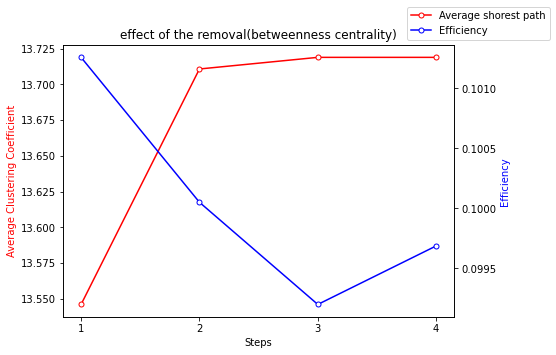

In [146]:
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Steps')
ax1.plot(removal_effect_betweenness_n['Average shorest path'], marker='o', color='r', mfc = "white", ms=5, label='Average shorest path')
ax1.set_ylabel('Average Clustering Coefficient', color='r')
#ax1.plot(removal_effect_betweenness3['LCC (%)'], marker='o', color='r', mfc = "white", alpha=0.5, ms=5, label='LCC (%)')
plt.xticks(range(0,len(removal_effect_betweenness_n.index.to_list())), removal_effect_betweenness_n.index,color='black')
ax2 = ax1.twinx()
ax2.plot(removal_effect_betweenness_n['Efficiency'], marker='o', color='b', mfc = "white", ms=5, label='Efficiency')
ax2.set_ylabel('Efficiency', color='b')
fig.legend(bbox_to_anchor=(1.1,1))
plt.title('effect of the removal(betweenness centrality)')
fig.savefig('the effect of the Non-sequential removal with flows (betweenness centrality)')
plt.show()

##### Sequential removal:

In [147]:
G5=G4.copy()
i = 0
removal_results = dict()
removal_results['original']=[original_percent_lcc, original_E, original_av_path]

while i<3:
    cen_london = nx.betweenness_centrality(G5, weight='flows' ,normalized=False)
    nx.set_node_attributes(G5, dict(cen_london), 'betweenness_centrality')
    
    df = pd.DataFrame(index=G5.nodes())
    df['station_name'] = pd.Series(nx.get_node_attributes(G5, 'station_name'))
    df['betweenness_centrality'] = pd.Series(nx.get_node_attributes(G5, 'betweenness_centrality'))
    df_sorted_dc = df.sort_values(['betweenness_centrality'], ascending=False)
    
    node_to_remove = df_sorted_dc.index[0]
    G5.remove_node(node_to_remove)
    
    percent_lcc, E = effect(G5)
    # we can see in the plot that the graph has more then one component
    # let's subset this graph to the largest connected component
    Gcc = sorted(nx.connected_components(G5), key=len, reverse=True)
    Gsub = G5.subgraph(Gcc[0])
    
    av_path = nx.average_shortest_path_length(Gsub)
    removal_results[node_to_remove] = [percent_lcc, E, av_path]
    i += 1

removal_effect_betweenness3 = pd.DataFrame.from_dict(removal_results, orient='index', columns=['LCC (%)', 'Efficiency', 'Average shorest path'])
removal_effect_betweenness3 = removal_effect_betweenness3.reset_index()
removal_effect_betweenness3 = removal_effect_betweenness3.rename({'index':'remove_station_name'}, axis=1)
#removal_effect_betweenness3['LCC (%)'] = removal_effect_betweenness3['LCC (%)']/original_percent_lcc_G4
#removal_effect_betweenness3['Efficiency'] = removal_effect_betweenness3['Efficiency']/original_E_G4
removal_effect_betweenness3

,remove_station_name,LCC (%),Efficiency,Average shorest path
0,original,100.0,0.101256,13.545998
1,West Hampstead,100.0,0.100050,13.710764
2,Piccadilly Circus,100.0,0.099794,13.735318
3,Leicester Square,100.0,0.099607,13.756009


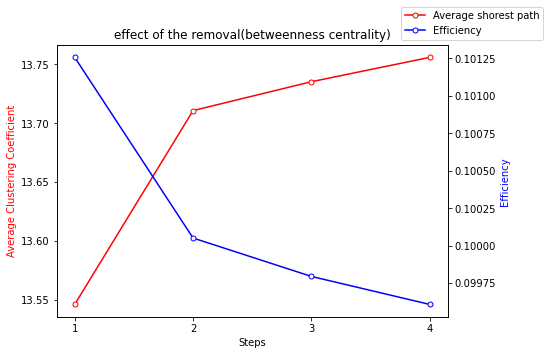

In [148]:
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Steps')
ax1.plot(removal_effect_betweenness3['Average shorest path'], marker='o', color='r', mfc = "white", ms=5, label='Average shorest path')
ax1.set_ylabel('Average Clustering Coefficient', color='r')
#ax1.plot(removal_effect_betweenness3['LCC (%)'], marker='o', color='r', mfc = "white", alpha=0.5, ms=5, label='LCC (%)')
plt.xticks(range(0,len(removal_effect_betweenness3.index.to_list())), removal_effect_betweenness3.index,color='black')
ax2 = ax1.twinx()
ax2.plot(removal_effect_betweenness3['Efficiency'], marker='o', color='b', mfc = "white", ms=5, label='Efficiency')
ax2.set_ylabel('Efficiency', color='b')
fig.legend(bbox_to_anchor=(1.1,1))
plt.title('effect of the removal(betweenness centrality)')
fig.savefig('the effect of the sequential removal with flows (betweenness centrality)')
plt.show()

## Spatial Interaction models

### Preparation OD

In [83]:
flow_OD = flow_OD[~(flow_OD["distance"]==0)]
flow_OD = flow_OD[~(flow_OD["jobs"]==0)]
flow_OD = flow_OD[~(flow_OD["population"]==0)]

In [84]:
#### Create Origin Destination matrix
OD = pd.pivot_table(flow_OD, 
                    values ="flows", 
                    index="station_origin", 
                    columns = "station_destination",
                    aggfunc=sum, 
                    margins=True)
OD.fillna(0, inplace=True)
OD = OD.astype(int)
OD.sort_values(by='All').tail(10)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Finsbury Park,0,0,19,156,39,0,6,1,0,34,...,16,4,113,18,0,0,0,2,0,24735
Canada Water,0,0,17,0,0,0,5,0,43,81,...,0,1,6,2,0,3,0,4,0,27026
King's Cross St. Pancras,0,0,22,842,160,0,7,2,0,135,...,38,8,71,214,0,3,0,12,0,28307
Bank and Monument,0,0,6,31,250,25,0,0,0,518,...,38,2,31,1,0,10,0,9,509,29494
Liverpool Street,0,0,12,384,150,0,3,3,0,121,...,5,1,15,53,61,12,0,1,0,31473
London Bridge,0,0,24,20,47,0,9,1,0,905,...,0,1,52,1,0,5,0,9,0,32593
Victoria,0,0,30,59,153,0,9,2,0,235,...,53,2,122,2,0,7,0,26,0,37517
Stratford,223,25,7,18,186,157,3,0,0,167,...,3,4,43,1,0,133,0,8,1106,59311
Waterloo,0,0,14,108,381,0,6,1,0,306,...,2,0,43,5,0,12,0,18,0,67314


In [85]:
#lets get total at origin and total at destinations
origin = OD.loc[:,'All'].to_dict()
destination = OD.loc['All',:].to_dict()

In [86]:
#lets add this data as population and jobs
flow_OD['population'] = flow_OD.station_origin.apply(lambda x: origin[x])
flow_OD['jobs'] = flow_OD.station_destination.apply(lambda x: destination[x])

In [87]:
#get distance between stations withion the network
flow_OD['distance'] = -1
for i, row in flow_OD.iterrows():
    source = row.station_origin
    target = row.station_destination
    distance = nx.shortest_path_length(G, source, target, weight='length', method='dijkstra')
    flow_OD.loc[i, 'distance'] = distance

# or you could use all_pairs_dijkstra_path_length(G, weight='length') to get all distances at once...
flow_OD

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


In [88]:
flow_OD_mat = pd.pivot_table(flow_OD, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flow_OD_mat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


### Attraction-Constrained Model

In [89]:
import scipy.stats

def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

In [90]:
from math import sqrt

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [91]:
#take the variables and produce logarithms of them
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    flow_OD[f"log_{x}"] = np.log(flow_OD[x])
    log_x_vars.append(f"log_{x}")


##### Parameter estimation

In [92]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
#create the formula (the "-1" indicates no intercept in the regression model).
attr_form = 'flows ~ station_origin + log_jobs + log_distance-1'
#run a destination constrained sim
attrSim = smf.glm(formula = attr_form, data=flow_OD, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(attrSim.summary().tables[0])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Mon, 01 May 2023   Deviance:                   1.8616e+06
Time:                        16:34:54   Pearson chi2:                 2.78e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         


##### Model Estimates

In [93]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(flow_OD.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
flow_OD = flow_OD.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(flow_OD.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
flow_OD = flow_OD.merge(D_j, on = "station_destination", how = "left" )

In [94]:
#create a coefficients dataframe from the attrSim model
#call the coefficients gamma_j
coefs = pd.DataFrame(attrSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)

In [95]:
#replace the unnecessary DestCodeNew and [] in the
#coefficients column of the coefs DataFrame
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
    
#then once you have done this you can join them back into the dataframes
flow_OD = flow_OD.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
flow_OD.drop(columns = ["coef"], inplace = True)
#check this has worked
flow_OD.head()

/tmp/ipykernel_1216/1884467254.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,78549,3.250439
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,3.250439
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,3.250439
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,3.250439
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,3.250439


In [96]:
#extract alpha and beta from the
#attrSim model
alpha_i= attrSim.params[0:397]
gamma = attrSim.params[398]
beta = -attrSim.params[399]

In [97]:
#create estimate for attrsimest2
#using the calculated gamma_j and alpha and beta values
#remember to log the new origin population
flow_OD["attrsimest1"] = np.exp(flow_OD["alpha_i"]+gamma*np.log(flow_OD["jobs"]) - beta*flow_OD["log_distance"])

#round these to integer values
#as we don't want half a person
flow_OD["attrsimest1"] = round(flow_OD["attrsimest1"],0)

#now we can convert the pivot table into a matrix
#called cdatasubmat7
flow_OD_mat2 = flow_OD.pivot_table(values ="attrsimest1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

#display the results
flow_OD_mat2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,16.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3749.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,21.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2882.0
Aldgate East,NaN,NaN,2.0,52.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3166.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,35.0,39.0,NaN,NaN,NaN,NaN,32.0,...,15.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4866.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,20.0,20.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3091.0


In [98]:
flow_OD_mat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [99]:
CalcRSqaured(flow_OD["flows"], flow_OD["attrsimest1"])

0.3882719536104893

In [100]:
CalcRMSE(flow_OD["flows"], flow_OD["attrsimest1"])

102.893

##### Scenario A

In [101]:
def new_sal(row):
    if row["station_destination"] == "Canary Wharf":
        val = row['jobs']/2
    else:
        val = row['jobs']
    return val
        
flow_OD["jobs_Scenario"] = flow_OD.apply(new_sal, axis =1)
flow_OD.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,D_j,alpha_i,attrsimest1,jobs_Scenario
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,78549,3.250439,55.0,78549.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,3.250439,1.0,442.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,3.250439,3.0,665.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,3.250439,66.0,29386.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,3.250439,49.0,15428.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,599,1208,3.250439,3.0,1208.0
6,Abbey Road,Custom House,0,599,845,3824.855630,6.395262,6.739337,8.249276,599,845,3.250439,3.0,845.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,7.466228,9.048280,599,1748,3.250439,3.0,1748.0
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,6.745236,8.784484,599,850,3.250439,2.0,850.0
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,6.415097,8.283576,599,611,3.250439,2.0,611.0


In [102]:
flow_OD["attrsimest2"] = np.exp(flow_OD["alpha_i"]+gamma*np.log(flow_OD["jobs_Scenario"]) - beta*flow_OD["log_distance"])

flow_OD["attrsimest2"] = round(flow_OD["attrsimest2"],0)
#now we can convert the pivot table into a matrix
flow_OD_mat4 = flow_OD.pivot_table(values ="attrsimest2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flow_OD_mat4

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,572.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,16.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3719.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,21.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2859.0
Aldgate East,NaN,NaN,2.0,52.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,35.0,39.0,NaN,NaN,NaN,NaN,32.0,...,15.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4790.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,20.0,20.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3059.0


In [103]:
#calculate some new Dj^gamma and d_ij^beta values
jobs_gamma = flow_OD["jobs"]**gamma
dist_beta = flow_OD["distance"]**-beta
#calcualte the first stage of the Ai values
flow_OD["Ai1"] = jobs_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(flow_OD.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
flow_OD = flow_OD.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [104]:
#to check everything works, recreate the original estimates
flow_OD["attrsimest3"] = flow_OD["A_i"]*flow_OD["O_i"]*jobs_gamma*dist_beta
#round
flow_OD["attrsimest3"] = round(flow_OD["attrsimest3"])
#check
flow_OD[["attrsimest1", "attrsimest3"]]

,attrsimest1,attrsimest3
0,55.0,55.0
1,1.0,1.0
2,3.0,3.0
3,66.0,66.0
4,49.0,49.0
...,...,...
61408,121.0,121.0
61409,259.0,259.0
61410,32.0,32.0
61411,98.0,98.0


In [105]:
#calculate some new O_i^alpha 
#call it Oi3_alpha
Dj3_gamma = flow_OD["jobs_Scenario"]**gamma

#calculate the first stage of the Bj values
flow_OD["Ai2"] = Dj3_gamma * dist_beta
#now do the sum over all is bit
A_i = pd.DataFrame(flow_OD.groupby(["station_origin"])["Ai2"].agg(np.sum))
#now divide into 1
A_i["Ai2"] = 1/A_i["Ai2"]
#rename the column
A_i.rename(columns={"Ai2":"A_i2"}, inplace=True)
#and write the B_j values back into the dataframe
flow_OD = flow_OD.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [106]:
#to check everything works, recreate the original estimates
flow_OD["attrsimest4"] = flow_OD["A_i2"]*flow_OD["O_i"]*Dj3_gamma*dist_beta
#round
flow_OD["attrsimest4"] = round(flow_OD["attrsimest4"])

In [107]:
flow_OD_mat5 = flow_OD.pivot_table(values ="attrsimest4", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flow_OD_mat5

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,17.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3745.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,22.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2884.0
Aldgate East,NaN,NaN,2.0,53.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,36.0,39.0,NaN,NaN,NaN,NaN,33.0,...,16.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4863.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,21.0,21.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3091.0


In [108]:
compare=pd.concat([pd.DataFrame(flow_OD_mat.loc['All',:]),pd.DataFrame(flow_OD_mat5.loc['All',:])], axis=1)
#compare = pd.DataFrame(compare.values.T,columns=compare.index,index=compare.columns.values)
compare.columns=['original', 'scenario_A']
compare['difference']=compare['original']-compare['scenario_A']
compare

,original,scenario_A,difference
station_destination,,,
Abbey Road,345.0,470.0,-125.0
Acton Central,750.0,393.0,357.0
Acton Town,2202.0,2182.0,20.0
Aldgate,7782.0,8836.0,-1054.0
Aldgate East,7932.0,9400.0,-1468.0
...,...,...,...
Woodford,706.0,666.0,40.0
Woodgrange Park,242.0,156.0,86.0
Woodside Park,745.0,609.0,136.0


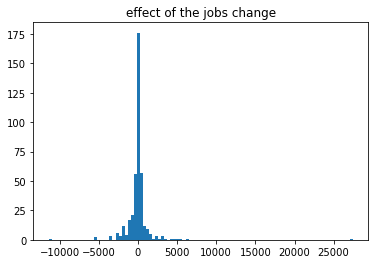

In [109]:
fig = plt.figure()
plt.hist(compare['difference'],bins=100)
plt.title('effect of the jobs change')
fig.savefig('Changes resulting from a 50% reduction in job opportunities')
plt.show()

In [110]:
mean_value = compare['difference'].mean()
var_value = compare['difference'].var()

print("Mean value of column:", mean_value)
print("Variance of column:", var_value)

Mean value of column: 1.6040100250626566
Variance of column: 3465720.8829989573


In [111]:
compare_sorted=compare.sort_values(['difference'], ascending=False)
compare_sorted[0:10]

,original,scenario_A,difference
station_destination,,,
Canary Wharf,58772.0,31311.0,27461.0
Oxford Circus,44368.0,37941.0,6427.0
Victoria,33251.0,27584.0,5667.0
Bank and Monument,78549.0,73531.0,5018.0
Hammersmith,18250.0,13542.0,4708.0
King's Cross St. Pancras,33330.0,29131.0,4199.0
Paddington,20193.0,16630.0,3563.0
Woolwich Arsenal,4428.0,1081.0,3347.0
Shoreditch High Street,7558.0,4485.0,3073.0


##### Scenario B

In [112]:
beta

0.878125252611097

In [113]:
#If the cost function is increased, the value of beta also needs to be increased
beta_1 = 1
beta_2 = 1.5

###### beta_1:

In [114]:
#create estimate for attrsimest2
#using the calculated gamma_j and alpha and beta values
#remember to log the new origin population
flow_OD["attrsimest5"] = np.exp(flow_OD["alpha_i"]+gamma*np.log(flow_OD["jobs"])-beta_1*flow_OD['log_distance'])

#round these to integer values
#as we don't want half a person
flow_OD["attrsimest5"] = round(flow_OD["attrsimest5"],0)

#now we can convert the pivot table into a matrix
#called cdatasubmat7
flow_OD_mat5 = flow_OD.pivot_table(values ="attrsimest5", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

#display the results
flow_OD_mat5

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,240.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,411.0
Acton Town,NaN,NaN,NaN,6.0,6.0,NaN,3.0,0.0,NaN,6.0,...,5.0,1.0,2.0,4.0,NaN,0.0,NaN,1.0,NaN,1215.0
Aldgate,NaN,NaN,1.0,NaN,19.0,NaN,NaN,0.0,NaN,8.0,...,1.0,NaN,1.0,1.0,NaN,0.0,NaN,0.0,NaN,1085.0
Aldgate East,NaN,NaN,1.0,22.0,NaN,NaN,0.0,0.0,NaN,8.0,...,1.0,0.0,1.0,1.0,NaN,0.0,NaN,0.0,NaN,1173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,11.0,12.0,NaN,NaN,NaN,NaN,10.0,...,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1495.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.0
Woodside Park,NaN,NaN,2.0,6.0,6.0,NaN,1.0,NaN,NaN,8.0,...,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,952.0


In [115]:
#calculate some new Dj^gamma and d_ij^beta values
job_gamma = flow_OD["jobs"]**gamma
dist_beta = flow_OD["distance"]**-beta_1
#calcualte the first stage of the Ai values
flow_OD["Ai3"] = job_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(flow_OD.groupby(["station_origin"])["Ai3"].agg(np.sum))
#now divide into 1
A_i["Ai3"] = 1/A_i["Ai3"]
A_i.rename(columns={"Ai3":"A_i3"}, inplace=True)
#and write the A_i values back into the dataframe
flow_OD = flow_OD.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [116]:
#to check everything works, recreate the original estimates
flow_OD["attrsimest6"] = flow_OD["A_i3"]*flow_OD["O_i"]*job_gamma*dist_beta
#round
flow_OD["attrsimest6"] = round(flow_OD["attrsimest6"])
flow_OD_mat6 = flow_OD.pivot_table(values ="attrsimest6", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flow_OD_mat6

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,17.0,17.0,NaN,10.0,1.0,NaN,19.0,...,16.0,3.0,5.0,13.0,NaN,1.0,NaN,2.0,NaN,3745.0
Aldgate,NaN,NaN,2.0,NaN,50.0,NaN,NaN,0.0,NaN,21.0,...,3.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2879.0
Aldgate East,NaN,NaN,2.0,58.0,NaN,NaN,1.0,0.0,NaN,23.0,...,4.0,1.0,2.0,2.0,NaN,1.0,NaN,1.0,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,35.0,39.0,NaN,NaN,NaN,NaN,32.0,...,14.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4871.0
Woodgrange Park,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,528.0
Woodside Park,NaN,NaN,5.0,20.0,20.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3090.0


In [117]:
compare_2=pd.concat([flow_OD_mat.loc['All',:],flow_OD_mat6.loc['All',:]], axis=1)
compare_2.columns=['original', 'beta=1']
compare_2['difference']=compare_2['original']-compare_2['beta=1']
compare_2

,original,beta=1,difference
station_destination,,,
Abbey Road,345.0,508.0,-163.0
Acton Central,750.0,379.0,371.0
Acton Town,2202.0,2132.0,70.0
Aldgate,7782.0,8820.0,-1038.0
Aldgate East,7932.0,9361.0,-1429.0
...,...,...,...
Woodford,706.0,634.0,72.0
Woodgrange Park,242.0,167.0,75.0
Woodside Park,745.0,582.0,163.0


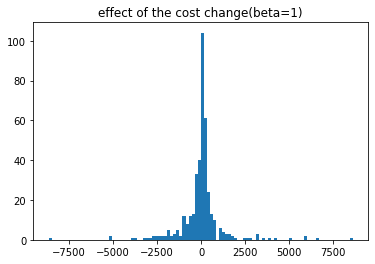

In [118]:
fig = plt.figure()
plt.hist(compare_2['difference'].drop(['All']),bins=100)
plt.title('effect of the cost change(beta=1)')
fig.savefig('the effect of the cost change(beta=1).png')
plt.show()

In [119]:
mean_value = compare_2['difference'].mean()
var_value = compare_2['difference'].var()

print("Mean value of column:", mean_value)
print("Variance of column:", var_value)

Mean value of column: 1.9849624060150375
Variance of column: 1693621.6681150105


In [120]:
compare2_sorted=compare_2.sort_values(['difference'], ascending=False)
compare2_sorted[0:10]

,original,beta=1,difference
station_destination,,,
Canary Wharf,58772.0,50156.0,8616.0
Oxford Circus,44368.0,37774.0,6594.0
Victoria,33251.0,27249.0,6002.0
Bank and Monument,78549.0,72642.0,5907.0
Hammersmith,18250.0,13225.0,5025.0
King's Cross St. Pancras,33330.0,29044.0,4286.0
Paddington,20193.0,16263.0,3930.0
Woolwich Arsenal,4428.0,941.0,3487.0
Wimbledon,6295.0,3132.0,3163.0


###### beta_2:

In [121]:
#create estimate for attrsimest2
#using the calculated gamma_j and alpha and beta values
#remember to log the new origin population
flow_OD["attrsimest7"] = np.exp(flow_OD["alpha_i"]+gamma*np.log(flow_OD["jobs"])-beta_2*flow_OD['log_distance'])

#round these to integer values
#as we don't want half a person
flow_OD["attrsimest7"] = round(flow_OD["attrsimest7"],0)

#now we can convert the pivot table into a matrix
#called cdatasubmat7
flow_OD_mat7 = flow_OD.pivot_table(values ="attrsimest7", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

#display the results
flow_OD_mat7

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3.0
Aldgate,NaN,NaN,0.0,NaN,1.0,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,18.0
Aldgate East,NaN,NaN,0.0,1.0,NaN,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [122]:
#calculate some new Dj^gamma and d_ij^beta values
job_gamma = flow_OD["jobs"]**gamma
dist_beta = flow_OD["distance"]**-beta_2
#calcualte the first stage of the Ai values
flow_OD["Ai4"] = job_gamma * dist_beta
#now do the sum over all js bit
A_i4 = pd.DataFrame(flow_OD.groupby(["station_origin"])["Ai4"].agg(np.sum))
#now divide into 1
A_i4["Ai4"] = 1/A_i4["Ai4"]
A_i4.rename(columns={"Ai4":"A_i4"}, inplace=True)
#and write the A_i values back into the dataframe
flow_OD = flow_OD.merge(A_i4, left_on="station_origin", right_index=True, how="left")

In [123]:
#to check everything works, recreate the original estimates
flow_OD["attrsimest8"] = flow_OD["A_i4"]*flow_OD["O_i"]*job_gamma*dist_beta
#round
flow_OD["attrsimest8"] = round(flow_OD["attrsimest8"])
flow_OD_mat8 = flow_OD.pivot_table(values ="attrsimest8", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flow_OD_mat8

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,12.0,12.0,NaN,13.0,0.0,NaN,14.0,...,12.0,2.0,3.0,16.0,NaN,1.0,NaN,1.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,60.0,NaN,NaN,0.0,NaN,16.0,...,1.0,NaN,1.0,1.0,NaN,0.0,NaN,0.0,NaN,2875.0
Aldgate East,NaN,NaN,1.0,76.0,NaN,NaN,0.0,0.0,NaN,18.0,...,1.0,0.0,1.0,1.0,NaN,0.0,NaN,0.0,NaN,3159.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,5.0,35.0,40.0,NaN,NaN,NaN,NaN,29.0,...,9.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,4871.0
Woodgrange Park,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533.0
Woodside Park,NaN,NaN,4.0,18.0,18.0,NaN,1.0,NaN,NaN,25.0,...,8.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,3098.0


In [124]:
compare_3=pd.concat([flow_OD_mat.loc['All',:],flow_OD_mat8.loc['All',:]], axis=1)
compare_3.columns=['original', 'beta=1.5']
compare_3['difference']=compare_3['original']-compare_3['beta=1.5']
compare_3

,original,beta=1.5,difference
station_destination,,,
Abbey Road,345.0,941.0,-596.0
Acton Central,750.0,360.0,390.0
Acton Town,2202.0,2249.0,-47.0
Aldgate,7782.0,8679.0,-897.0
Aldgate East,7932.0,9122.0,-1190.0
...,...,...,...
Woodford,706.0,641.0,65.0
Woodgrange Park,242.0,218.0,24.0
Woodside Park,745.0,651.0,94.0


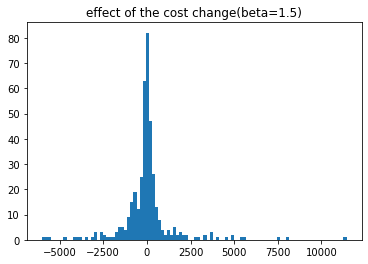

In [125]:
fig = plt.figure()
plt.hist(compare_3['difference'].drop(['All']),bins=100)
plt.title('effect of the cost change(beta=1.5)')
fig.savefig('the effect of the cost change(beta=1.5).png')
plt.show()

In [126]:
mean_value = compare_3['difference'].mean()
var_value = compare_3['difference'].var()

print("Mean value of column:", mean_value)
print("Variance of column:", var_value)

Mean value of column: 3.8095238095238093
Variance of column: 2246053.732471882


In [127]:
compare3_sorted=compare_3.sort_values(['difference'], ascending=False)
compare3_sorted[0:10]

,original,beta=1.5,difference
station_destination,,,
Canary Wharf,58772.0,47336.0,11436.0
Oxford Circus,44368.0,36280.0,8088.0
Victoria,33251.0,25660.0,7591.0
Bank and Monument,78549.0,72955.0,5594.0
Hammersmith,18250.0,12864.0,5386.0
Paddington,20193.0,15219.0,4974.0
Farringdon,25592.0,20684.0,4908.0
King's Cross St. Pancras,33330.0,28696.0,4634.0
Wimbledon,6295.0,2272.0,4023.0
